

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [2]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [3]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
%reload_ext autoreload

### Initial Parameters

In [5]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },    
    'pretrained_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':90},
        'lenet':{'dropout':0.2, 'epochs':90},
        'custom':{'dropout':0.2, 'epochs':90},
        'vgg':{'dropout':0.1, 'epochs':90},
        'resnet':{'dropout':0.2, 'epochs':90},
        'pretrained':{'dropout':0.2, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-08-18 20:22:20,689: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json


In [6]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [7]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [8]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

(500, 32, 32, 3) (500,)
(10000, 32, 32, 3) (10000,)


In [16]:
!pwd  

/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification


In [18]:
def save_images(image_folder_path, images, labels):
    i = 0
    
    if not os.path.exists(image_folder_path):
        os.makedirs(image_folder_path)
    for class_ in params.classes:
        image_class_path = os.path.join(image_folder_path, class_)
        if not os.path.exists(image_class_path):
            os.makedirs(image_class_path)    
    
    print(f'save images to {image_folder_path}')
    for train_image, train_label  in zip(images, labels):
        i = i + 1
        image = Image.fromarray(train_image)
        image_class_path = os.path.join(image_folder_path, f'{classes[train_label]}')
        image_path = os.path.join(image_class_path, f"{i}.png")
        image.save(image_path)    
        


In [ ]:
image_folder_path = os.path.join(params.data_path, 'data', f'{data_name}_{params.train_image_count}')
save_images(image_folder_path, train_images, train_labels)

In [19]:
image_folder_path = os.path.join(params.data_path, 'data', f'{data_name}_test')
save_images(image_folder_path, test_images, test_labels)

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test


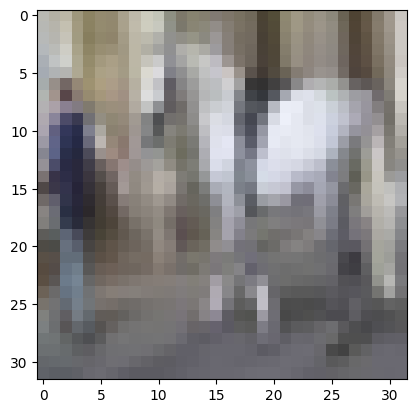

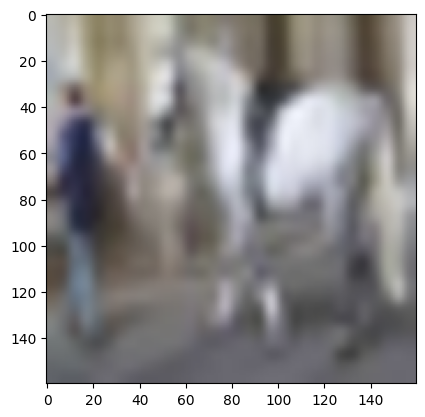

(32, 32, 3) (160, 160, 3)


In [28]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(160, 160) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [29]:
# train_images = resize_images(train_images, input_shape)
# test_images = resize_images(test_images, input_shape)

# print(train_images.shape, type(train_images), train_images.dtype)
# print(test_images.shape, type(test_images), test_images.dtype) 



### Data Explore 

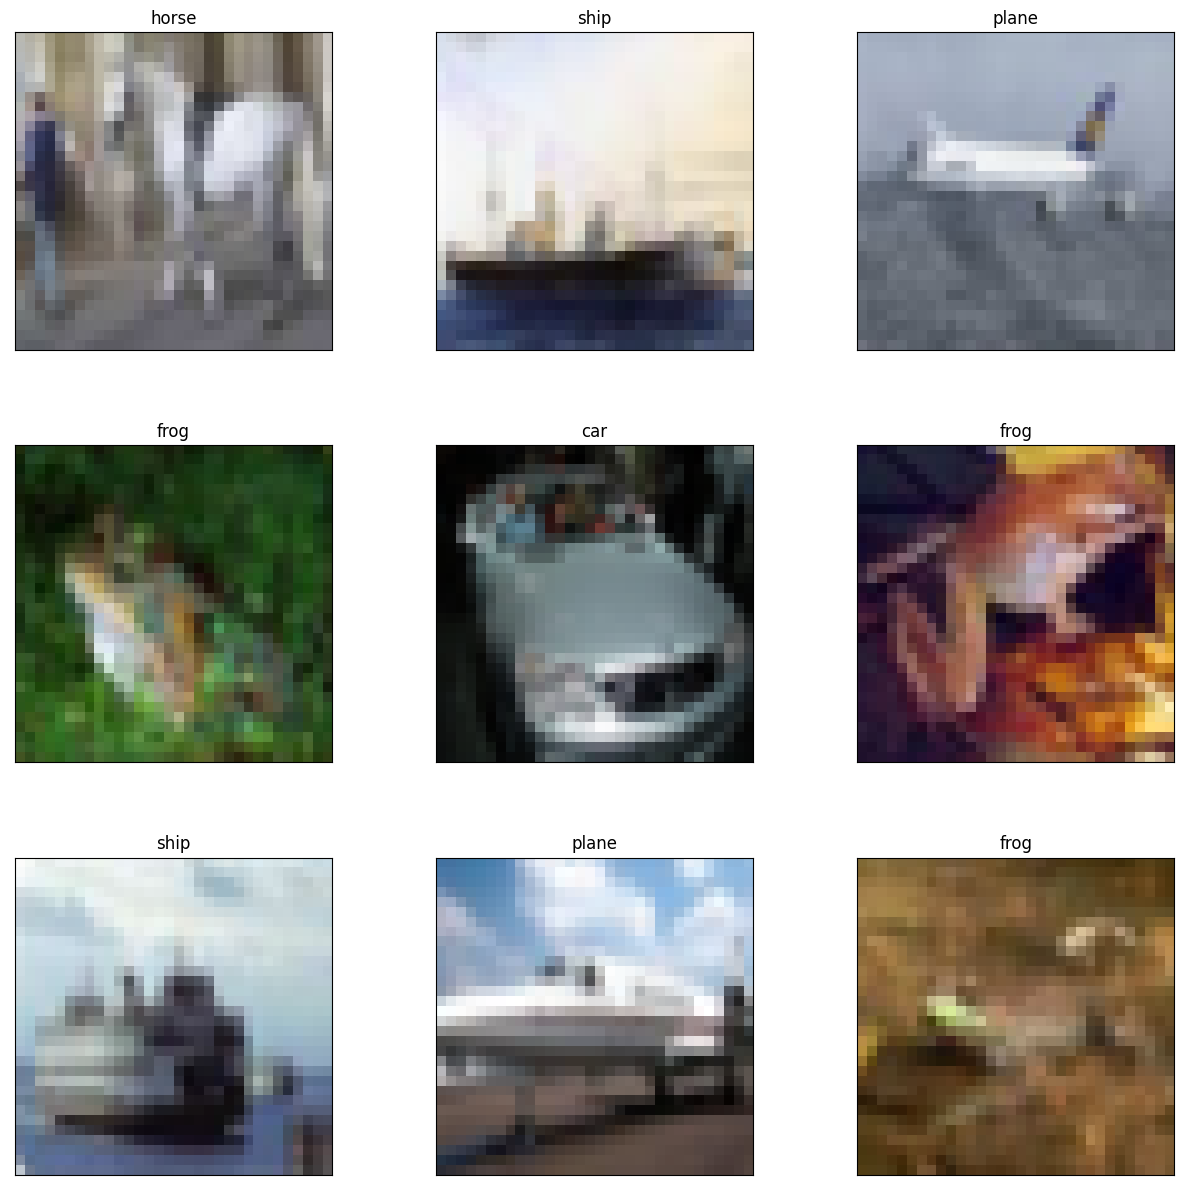

In [30]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

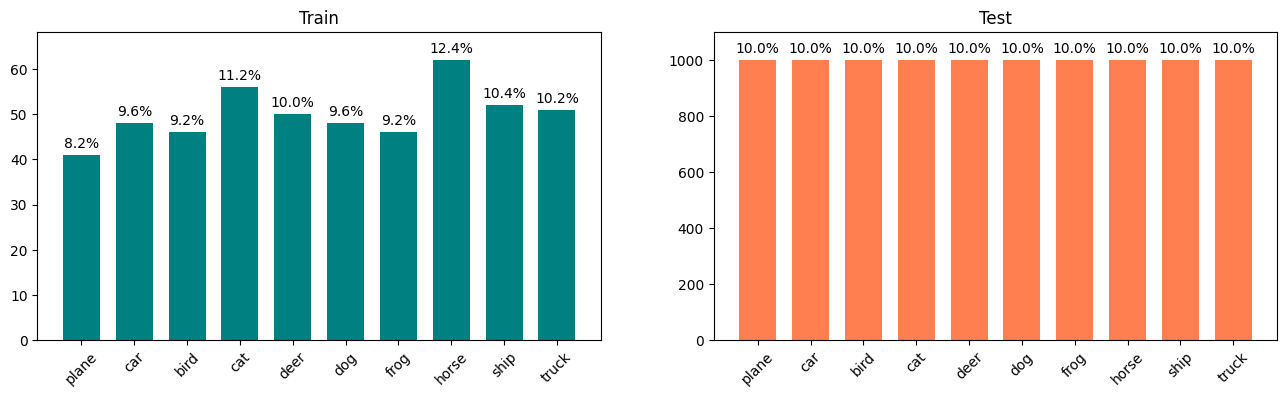

In [31]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [32]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [33]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [34]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

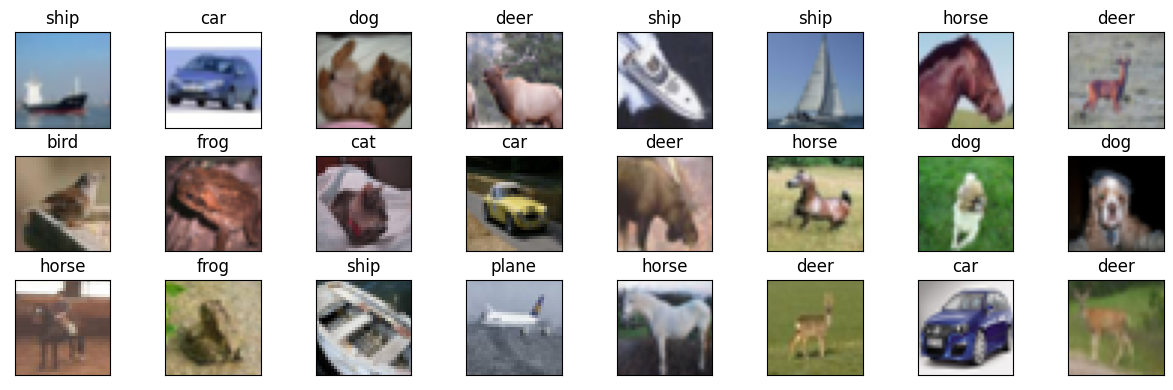

In [35]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [36]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

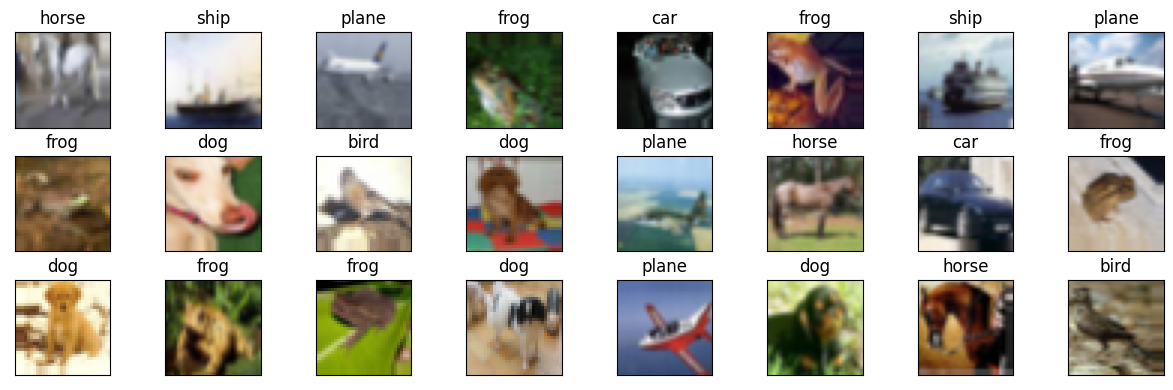

In [37]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

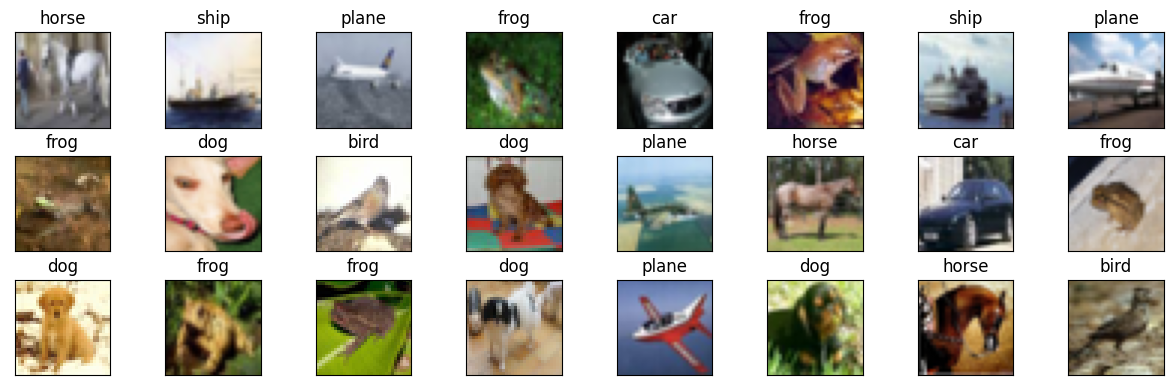

In [38]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [39]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [40]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


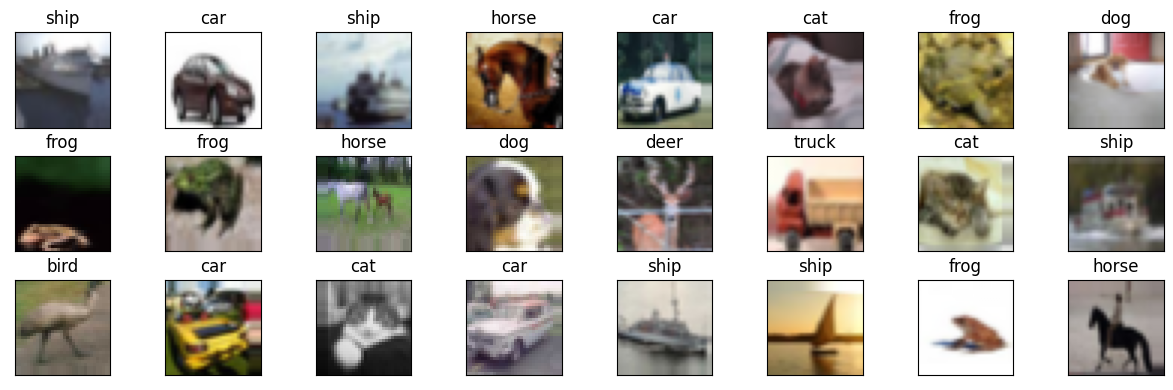

In [41]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [22]:
rescale = tf.keras.layers.Rescaling(1./255.0, offset=0)

### MLP

2022-08-16 09:46:01,496: INFO: model_params.mlp1.dropout=0.1
2022-08-16 09:46:01,497: INFO: model_params.mlp1.layer_count=1
2022-08-16 09:46:01,498: INFO: model_params.mlp1.units=128
2022-08-16 09:46:01,539: INFO: learning_rate=0.001
2022-08-16 09:46:01,539: INFO: model_params.mlp1.clip_value=None
2022-08-16 09:46:01,548: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable 

2022-08-16 09:46:01,562: INFO: model_params.mlp1.epochs=90
2022-08-16 09:46:01,562: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1, monitor=val_accuracy)
2022-08-16 09:46:01,563: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:46:01,563: INFO: use LearningRateScheduler()
2022-08-16 09:46:01,564: INFO: steps_per_epoch=15
2022-08-16 09:46:01,565: INFO: start training
2022-08-16 09:46:01,565: INFO: use_class_weight=False


Epoch 1/90
 1/15 [=>............................] - ETA: 10s - loss: 2.3503 - accuracy: 0.1562INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


2022-08-16 09:46:03,829: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 2s 111ms/step - loss: 3.0667 - accuracy: 0.1208 - val_loss: 2.3524 - val_accuracy: 0.1685 - lr: 0.0010
Epoch 2/90
 1/15 [=>............................] - ETA: 0s - loss: 2.5780 - accuracy: 0.0625INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


2022-08-16 09:46:05,042: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 1s 86ms/step - loss: 2.3106 - accuracy: 0.1542 - val_loss: 2.1892 - val_accuracy: 0.1704 - lr: 0.0010
Epoch 3/90
15/15 [==============================] - 1s 39ms/step - loss: 2.1594 - accuracy: 0.2146 - val_loss: 2.1638 - val_accuracy: 0.1687 - lr: 0.0010
Epoch 4/90
 1/15 [=>............................] - ETA: 0s - loss: 2.1360 - accuracy: 0.1562INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


2022-08-16 09:46:06,798: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 1s 85ms/step - loss: 2.1077 - accuracy: 0.2208 - val_loss: 2.1405 - val_accuracy: 0.1958 - lr: 0.0010
Epoch 5/90
 1/15 [=>............................] - ETA: 0s - loss: 2.2434 - accuracy: 0.1250INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


2022-08-16 09:46:08,008: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 1s 86ms/step - loss: 2.0836 - accuracy: 0.2167 - val_loss: 2.1339 - val_accuracy: 0.2013 - lr: 0.0010
Epoch 6/90
 1/15 [=>............................] - ETA: 0s - loss: 2.0957 - accuracy: 0.2188INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


2022-08-16 09:46:09,223: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 1s 86ms/step - loss: 2.0505 - accuracy: 0.2604 - val_loss: 2.0760 - val_accuracy: 0.2340 - lr: 0.0010
Epoch 7/90
15/15 [==============================] - 1s 41ms/step - loss: 2.0134 - accuracy: 0.2542 - val_loss: 2.0680 - val_accuracy: 0.2266 - lr: 0.0010
Epoch 8/90
 1/15 [=>............................] - ETA: 0s - loss: 2.0468 - accuracy: 0.1875INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


2022-08-16 09:46:11,035: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 1s 87ms/step - loss: 1.9302 - accuracy: 0.2937 - val_loss: 2.0271 - val_accuracy: 0.2534 - lr: 0.0010
Epoch 9/90
 1/15 [=>............................] - ETA: 0s - loss: 1.9431 - accuracy: 0.3438INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


2022-08-16 09:46:12,446: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 1s 100ms/step - loss: 1.9080 - accuracy: 0.3229 - val_loss: 2.0207 - val_accuracy: 0.2837 - lr: 0.0010
Epoch 10/90
15/15 [==============================] - 1s 39ms/step - loss: 1.8544 - accuracy: 0.3354 - val_loss: 2.0119 - val_accuracy: 0.2647 - lr: 0.0010
Epoch 11/90
15/15 [==============================] - 1s 44ms/step - loss: 1.8233 - accuracy: 0.3646 - val_loss: 2.0061 - val_accuracy: 0.2742 - lr: 0.0010
Epoch 12/90
15/15 [==============================] - 1s 64ms/step - loss: 1.8049 - accuracy: 0.3646 - val_loss: 2.0129 - val_accuracy: 0.2690 - lr: 0.0010
Epoch 13/90
15/15 [==============================] - 2s 108ms/step - loss: 1.7980 - accuracy: 0.3646 - val_loss: 2.0181 - val_accuracy: 0.2723 - lr: 0.0010
Epoch 14/90
15/15 [==============================] - 2s 174ms/step - loss: 1.7753 - accuracy: 0.3667 - val_loss: 2.0210 - val_accuracy: 0.2754 - lr: 0.0010
Epoch 15/90
15/15 [==============================] - 3s 192ms/step - loss: 1.76

2022-08-16 09:46:24,653: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 3s 242ms/step - loss: 1.7039 - accuracy: 0.4229 - val_loss: 1.9842 - val_accuracy: 0.2854 - lr: 0.0010
Epoch 17/90
15/15 [==============================] - 2s 119ms/step - loss: 1.7265 - accuracy: 0.3938 - val_loss: 2.0070 - val_accuracy: 0.2790 - lr: 0.0010
Epoch 18/90
12/15 [=======================>......] - ETA: 0s - loss: 1.6905 - accuracy: 0.4375INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


2022-08-16 09:46:28,324: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 2s 140ms/step - loss: 1.6923 - accuracy: 0.4354 - val_loss: 1.9980 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 19/90
15/15 [==============================] - 2s 112ms/step - loss: 1.6595 - accuracy: 0.4563 - val_loss: 1.9838 - val_accuracy: 0.2855 - lr: 0.0010
Epoch 20/90
10/15 [===================>..........] - ETA: 0s - loss: 1.6464 - accuracy: 0.4344INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


2022-08-16 09:46:32,185: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 2s 162ms/step - loss: 1.6591 - accuracy: 0.4354 - val_loss: 1.9849 - val_accuracy: 0.2926 - lr: 0.0010
Epoch 21/90
15/15 [==============================] - 2s 113ms/step - loss: 1.6265 - accuracy: 0.4708 - val_loss: 2.0098 - val_accuracy: 0.2837 - lr: 0.0010
Epoch 22/90
15/15 [==============================] - 1s 49ms/step - loss: 1.6353 - accuracy: 0.4729 - val_loss: 2.0260 - val_accuracy: 0.2783 - lr: 0.0010
Epoch 23/90
15/15 [==============================] - 1s 38ms/step - loss: 1.6490 - accuracy: 0.4271 - val_loss: 2.0126 - val_accuracy: 0.2793 - lr: 0.0010
Epoch 24/90
15/15 [==============================] - 1s 39ms/step - loss: 1.6024 - accuracy: 0.4500 - val_loss: 2.0468 - val_accuracy: 0.2698 - lr: 0.0010
Epoch 25/90
15/15 [==============================] - 1s 38ms/step - loss: 1.5762 - accuracy: 0.4896 - val_loss: 2.0292 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 26/90
15/15 [==============================] - 1s 39ms/step - loss: 1.5657

2022-08-16 09:46:42,249: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 1s 85ms/step - loss: 1.3610 - accuracy: 0.5833 - val_loss: 2.0357 - val_accuracy: 0.2966 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/90
15/15 [==============================] - 1s 38ms/step - loss: 1.3384 - accuracy: 0.5604 - val_loss: 2.0113 - val_accuracy: 0.2944 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/90
15/15 [==============================] - 1s 39ms/step - loss: 1.3355 - accuracy: 0.5646 - val_loss: 2.0203 - val_accuracy: 0.2913 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/90
15/15 [==============================] - 1s 39ms/step - loss: 1.2845 - accuracy: 0.5979 - val_loss: 2.0243 - val_accuracy: 0.2934 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/90
15/15 [==============================] - 1s 39ms/step - loss: 1.2839 - accuracy: 0.5875 - val_loss: 2.02

2022-08-16 09:46:46,195: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1/assets


15/15 [==============================] - 1s 85ms/step - loss: 1.3192 - accuracy: 0.5896 - val_loss: 2.0180 - val_accuracy: 0.2973 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
15/15 [==============================] - 1s 39ms/step - loss: 1.2990 - accuracy: 0.5833 - val_loss: 2.0297 - val_accuracy: 0.2888 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/90
15/15 [==============================] - 1s 39ms/step - loss: 1.2882 - accuracy: 0.5792 - val_loss: 2.0294 - val_accuracy: 0.2937 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/90
15/15 [==============================] - 1s 38ms/step - loss: 1.2782 - accuracy: 0.6146 - val_loss: 2.0251 - val_accuracy: 0.2931 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/90
15/15 [==============================] - 1s 39ms/step - loss: 1.2741 - accuracy: 0.6062 - val_loss: 2.02

Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/90
15/15 [==============================] - 1s 39ms/step - loss: 1.2015 - accuracy: 0.6333 - val_loss: 2.0446 - val_accuracy: 0.2915 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/90
 1/15 [=>............................] - ETA: 0s - loss: 1.3927 - accuracy: 0.5312
Epoch 79: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
15/15 [==============================] - 1s 39ms/step - loss: 1.1682 - accuracy: 0.6354 - val_loss: 2.0451 - val_accuracy: 0.2916 - lr: 1.0000e-05
Epoch 00080: Still keep learning rate 1e-05 instead of 0.0001
Epoch 80/90
15/15 [==============================] - 1s 47ms/step - loss: 1.1918 - accuracy: 0.6354 - val_loss: 2.0449 - val_accuracy: 0.2923 - lr: 1.0000e-05
Epoch 00081: Still keep learning rate 1e-05 instead of 0.0001
Epoch 81/90
15/15 [==============================] - 1s 39ms/step - loss: 1.1757 - accuracy: 0.6396 - val_los

2022-08-16 09:47:28,047: INFO: finish training [elapsed time: 86.48 seconds]


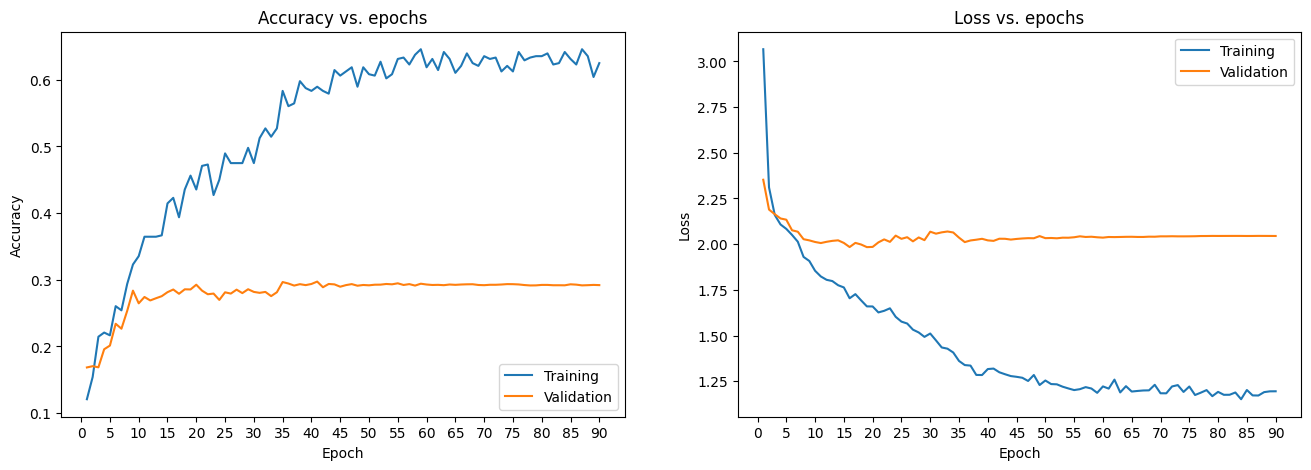

2022-08-16 09:47:28,493: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 0s 1ms/step


2022-08-16 09:47:30,619: INFO: test loss:2.0180
2022-08-16 09:47:30,620: INFO: test accuracy:0.2973
2022-08-16 09:47:30,621: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-16 09:47:30,622: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-16 09:47:30,623: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator


----------------------------------------save model results and generator----------------------------------------


2022-08-16 09:47:30,624: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator


----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 0s 1ms/step


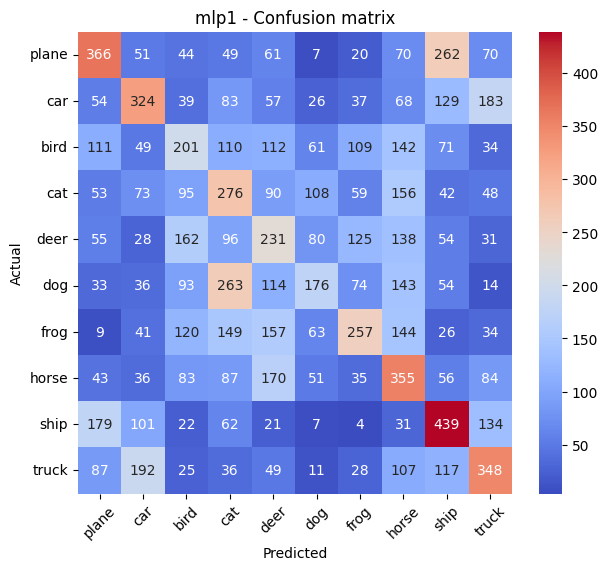

----------------------------------------models----------------------------------------


model_name               program_name  weight_number  train_time  \
1       mlp1  cifar10_0816_cnt_50.ipynb         394634        86.5   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:47      1.2401      2.018           0.646         0.2973   

   train_auc  test_auc  
1      0.926    0.7458

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-16 09:47:32,306: INFO: model_params.lenet1.dropout=0.2
2022-08-16 09:47:32,401: INFO: learning_rate=0.001
2022-08-16 09:47:32,402: INFO: model_params.lenet1.clip_value=None
2022-08-16 09:47:32,408: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0    

2022-08-16 09:47:32,437: INFO: model_params.lenet1.epochs=90
2022-08-16 09:47:32,437: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1, monitor=val_accuracy)
2022-08-16 09:47:32,438: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:47:32,438: INFO: use LearningRateScheduler()
2022-08-16 09:47:32,439: INFO: steps_per_epoch=15
2022-08-16 09:47:32,440: INFO: start training
2022-08-16 09:47:32,440: INFO: use_class_weight=False


Epoch 1/90
14/15 [===========================>..] - ETA: 0s - loss: 2.8679 - accuracy: 0.1384

2022-08-16 09:47:37,558: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:47:38,146: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 6s 272ms/step - loss: 2.8447 - accuracy: 0.1396 - val_loss: 2.2970 - val_accuracy: 0.1083 - lr: 0.0010
Epoch 2/90
12/15 [=======================>......] - ETA: 0s - loss: 2.2711 - accuracy: 0.1953

2022-08-16 09:47:41,218: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:47:41,818: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 261ms/step - loss: 2.2295 - accuracy: 0.1979 - val_loss: 2.2832 - val_accuracy: 0.1575 - lr: 0.0010
Epoch 3/90
15/15 [==============================] - ETA: 0s - loss: 2.0312 - accuracy: 0.2792

2022-08-16 09:47:45,186: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:47:45,781: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 280ms/step - loss: 2.0312 - accuracy: 0.2792 - val_loss: 2.2676 - val_accuracy: 0.1598 - lr: 0.0010
Epoch 4/90
15/15 [==============================] - ETA: 0s - loss: 1.9623 - accuracy: 0.2937

2022-08-16 09:47:48,534: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:47:49,134: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 238ms/step - loss: 1.9623 - accuracy: 0.2937 - val_loss: 2.2577 - val_accuracy: 0.1645 - lr: 0.0010
Epoch 5/90
11/15 [=====================>........] - ETA: 0s - loss: 1.8808 - accuracy: 0.3409

2022-08-16 09:47:52,217: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:47:52,807: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 260ms/step - loss: 1.8848 - accuracy: 0.3354 - val_loss: 2.2362 - val_accuracy: 0.1700 - lr: 0.0010
Epoch 6/90
11/15 [=====================>........] - ETA: 0s - loss: 1.8652 - accuracy: 0.3381

2022-08-16 09:47:55,769: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:47:56,383: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 254ms/step - loss: 1.8563 - accuracy: 0.3479 - val_loss: 2.2168 - val_accuracy: 0.1749 - lr: 0.0010
Epoch 7/90
15/15 [==============================] - 1s 53ms/step - loss: 1.7775 - accuracy: 0.3625 - val_loss: 2.2204 - val_accuracy: 0.1514 - lr: 0.0010
Epoch 8/90
15/15 [==============================] - 1s 54ms/step - loss: 1.6409 - accuracy: 0.4146 - val_loss: 2.2007 - val_accuracy: 0.1614 - lr: 0.0010
Epoch 9/90
15/15 [==============================] - 1s 53ms/step - loss: 1.5675 - accuracy: 0.4583 - val_loss: 2.2026 - val_accuracy: 0.1673 - lr: 0.0010
Epoch 10/90
14/15 [===========================>..] - ETA: 0s - loss: 1.5908 - accuracy: 0.4554

2022-08-16 09:48:00,704: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:01,312: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 189ms/step - loss: 1.5861 - accuracy: 0.4521 - val_loss: 2.1717 - val_accuracy: 0.1928 - lr: 0.0010
Epoch 11/90
15/15 [==============================] - 1s 53ms/step - loss: 1.4700 - accuracy: 0.4604 - val_loss: 2.1774 - val_accuracy: 0.1888 - lr: 0.0010
Epoch 12/90
15/15 [==============================] - ETA: 0s - loss: 1.3797 - accuracy: 0.4833

2022-08-16 09:48:04,080: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:04,897: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 202ms/step - loss: 1.3797 - accuracy: 0.4833 - val_loss: 2.1680 - val_accuracy: 0.1988 - lr: 0.0010
Epoch 13/90
14/15 [===========================>..] - ETA: 0s - loss: 1.3259 - accuracy: 0.5223

2022-08-16 09:48:07,018: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:07,687: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 198ms/step - loss: 1.3305 - accuracy: 0.5229 - val_loss: 2.1745 - val_accuracy: 0.2037 - lr: 0.0010
Epoch 14/90
15/15 [==============================] - ETA: 0s - loss: 1.2135 - accuracy: 0.5917

2022-08-16 09:48:10,580: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:11,163: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 247ms/step - loss: 1.2135 - accuracy: 0.5917 - val_loss: 2.2071 - val_accuracy: 0.2059 - lr: 0.0010
Epoch 15/90
11/15 [=====================>........] - ETA: 0s - loss: 1.2313 - accuracy: 0.5483

2022-08-16 09:48:14,288: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:14,891: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 265ms/step - loss: 1.2236 - accuracy: 0.5562 - val_loss: 2.1712 - val_accuracy: 0.2236 - lr: 0.0010
Epoch 16/90
15/15 [==============================] - 1s 72ms/step - loss: 1.1769 - accuracy: 0.6104 - val_loss: 2.2873 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 17/90
15/15 [==============================] - 1s 54ms/step - loss: 1.1565 - accuracy: 0.5771 - val_loss: 2.2732 - val_accuracy: 0.2067 - lr: 0.0010
Epoch 18/90
14/15 [===========================>..] - ETA: 0s - loss: 1.0092 - accuracy: 0.6540

2022-08-16 09:48:18,989: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:19,584: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 206ms/step - loss: 1.0065 - accuracy: 0.6542 - val_loss: 2.1477 - val_accuracy: 0.2477 - lr: 0.0010
Epoch 19/90
15/15 [==============================] - 1s 101ms/step - loss: 1.0084 - accuracy: 0.6333 - val_loss: 2.2784 - val_accuracy: 0.2258 - lr: 0.0010
Epoch 20/90
15/15 [==============================] - 1s 101ms/step - loss: 0.8923 - accuracy: 0.7042 - val_loss: 2.2493 - val_accuracy: 0.2434 - lr: 0.0010
Epoch 21/90
15/15 [==============================] - 2s 109ms/step - loss: 0.9010 - accuracy: 0.6958 - val_loss: 2.2434 - val_accuracy: 0.2458 - lr: 0.0010
Epoch 22/90
11/15 [=====================>........] - ETA: 0s - loss: 0.8213 - accuracy: 0.7301

2022-08-16 09:48:27,088: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:27,676: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 262ms/step - loss: 0.8402 - accuracy: 0.7167 - val_loss: 2.3065 - val_accuracy: 0.2628 - lr: 0.0010
Epoch 23/90
15/15 [==============================] - ETA: 0s - loss: 0.7831 - accuracy: 0.7292

2022-08-16 09:48:30,751: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:31,551: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 275ms/step - loss: 0.7831 - accuracy: 0.7292 - val_loss: 2.3216 - val_accuracy: 0.2705 - lr: 0.0010
Epoch 24/90
15/15 [==============================] - 1s 54ms/step - loss: 0.7947 - accuracy: 0.7167 - val_loss: 2.4675 - val_accuracy: 0.2446 - lr: 0.0010
Epoch 25/90
15/15 [==============================] - 1s 55ms/step - loss: 0.7151 - accuracy: 0.7812 - val_loss: 2.4460 - val_accuracy: 0.2487 - lr: 0.0010
Epoch 26/90
14/15 [===========================>..] - ETA: 0s - loss: 0.6757 - accuracy: 0.7746

2022-08-16 09:48:35,119: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:35,702: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 185ms/step - loss: 0.6776 - accuracy: 0.7667 - val_loss: 2.3744 - val_accuracy: 0.2760 - lr: 0.0010
Epoch 27/90
14/15 [===========================>..] - ETA: 0s - loss: 0.6174 - accuracy: 0.7812

2022-08-16 09:48:37,728: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:38,330: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 187ms/step - loss: 0.6171 - accuracy: 0.7812 - val_loss: 2.3976 - val_accuracy: 0.2904 - lr: 0.0010
Epoch 28/90
15/15 [==============================] - 1s 82ms/step - loss: 0.6414 - accuracy: 0.7729 - val_loss: 2.3694 - val_accuracy: 0.2899 - lr: 0.0010
Epoch 29/90
15/15 [==============================] - ETA: 0s - loss: 0.5895 - accuracy: 0.8125

2022-08-16 09:48:42,228: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:43,084: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 256ms/step - loss: 0.5895 - accuracy: 0.8125 - val_loss: 2.4719 - val_accuracy: 0.2948 - lr: 0.0010
Epoch 30/90
15/15 [==============================] - 2s 129ms/step - loss: 0.5566 - accuracy: 0.8104 - val_loss: 2.5243 - val_accuracy: 0.2935 - lr: 0.0010
Epoch 31/90
11/15 [=====================>........] - ETA: 0s - loss: 0.5353 - accuracy: 0.8182

2022-08-16 09:48:48,162: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:48,753: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 271ms/step - loss: 0.5254 - accuracy: 0.8229 - val_loss: 2.3808 - val_accuracy: 0.3155 - lr: 0.0010
Epoch 32/90
15/15 [==============================] - 1s 54ms/step - loss: 0.4645 - accuracy: 0.8625 - val_loss: 2.4969 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 33/90
12/15 [=======================>......] - ETA: 0s - loss: 0.4007 - accuracy: 0.8828
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
15/15 [==============================] - 1s 55ms/step - loss: 0.4233 - accuracy: 0.8604 - val_loss: 2.4701 - val_accuracy: 0.3148 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
14/15 [===========================>..] - ETA: 0s - loss: 0.4191 - accuracy: 0.8504

2022-08-16 09:48:52,409: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:53,011: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 193ms/step - loss: 0.4156 - accuracy: 0.8521 - val_loss: 2.4725 - val_accuracy: 0.3243 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/90
14/15 [===========================>..] - ETA: 0s - loss: 0.3784 - accuracy: 0.8750

2022-08-16 09:48:55,245: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:55,836: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 201ms/step - loss: 0.3762 - accuracy: 0.8750 - val_loss: 2.4975 - val_accuracy: 0.3299 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/90
15/15 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.8729

2022-08-16 09:48:58,839: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:48:59,441: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 256ms/step - loss: 0.3739 - accuracy: 0.8729 - val_loss: 2.5158 - val_accuracy: 0.3342 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/90
15/15 [==============================] - 2s 127ms/step - loss: 0.3649 - accuracy: 0.8833 - val_loss: 2.5020 - val_accuracy: 0.3320 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/90
15/15 [==============================] - 2s 128ms/step - loss: 0.3524 - accuracy: 0.8896 - val_loss: 2.4711 - val_accuracy: 0.3299 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/90
15/15 [==============================] - 2s 129ms/step - loss: 0.3730 - accuracy: 0.8771 - val_loss: 2.4682 - val_accuracy: 0.3286 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/90
11/15 [=====================>........] - ETA: 0s - loss: 0.3304 - accuracy: 0.8807

2022-08-16 09:49:07,677: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:49:08,272: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 242ms/step - loss: 0.3210 - accuracy: 0.8813 - val_loss: 2.5114 - val_accuracy: 0.3345 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
14/15 [===========================>..] - ETA: 0s - loss: 0.3121 - accuracy: 0.9040

2022-08-16 09:49:10,518: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:49:11,122: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 204ms/step - loss: 0.3145 - accuracy: 0.9021 - val_loss: 2.5477 - val_accuracy: 0.3347 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
15/15 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.8896

2022-08-16 09:49:13,869: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:49:14,483: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 237ms/step - loss: 0.3291 - accuracy: 0.8896 - val_loss: 2.4993 - val_accuracy: 0.3379 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/90
12/15 [=======================>......] - ETA: 0s - loss: 0.3270 - accuracy: 0.8984

2022-08-16 09:49:17,607: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:49:18,202: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 263ms/step - loss: 0.3287 - accuracy: 0.8979 - val_loss: 2.5075 - val_accuracy: 0.3454 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/90
15/15 [==============================] - 2s 126ms/step - loss: 0.2961 - accuracy: 0.9167 - val_loss: 2.5320 - val_accuracy: 0.3450 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/90
15/15 [==============================] - 1s 71ms/step - loss: 0.3187 - accuracy: 0.9062 - val_loss: 2.5431 - val_accuracy: 0.3442 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/90
15/15 [==============================] - 1s 54ms/step - loss: 0.2831 - accuracy: 0.9292 - val_loss: 2.6325 - val_accuracy: 0.3402 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/90
15/15 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.8979

2022-08-16 09:49:24,032: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:49:24,620: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 204ms/step - loss: 0.3289 - accuracy: 0.8979 - val_loss: 2.6065 - val_accuracy: 0.3475 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/90
14/15 [===========================>..] - ETA: 0s - loss: 0.2890 - accuracy: 0.9174

2022-08-16 09:49:26,686: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:49:27,265: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets



Epoch 48: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
15/15 [==============================] - 3s 188ms/step - loss: 0.2891 - accuracy: 0.9208 - val_loss: 2.5866 - val_accuracy: 0.3486 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/90
15/15 [==============================] - 1s 53ms/step - loss: 0.3003 - accuracy: 0.8979 - val_loss: 2.5904 - val_accuracy: 0.3481 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/90
15/15 [==============================] - 1s 53ms/step - loss: 0.2838 - accuracy: 0.9125 - val_loss: 2.5938 - val_accuracy: 0.3465 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/90
15/15 [==============================] - 1s 55ms/step - loss: 0.2933 - accuracy: 0.9208 - val_loss: 2.5993 - val_accuracy: 0.3468 - lr: 1.0000e-04
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
Epoch 52/90
15/15 [=============================

2022-08-16 09:49:33,669: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:49:34,262: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 3s 239ms/step - loss: 0.2710 - accuracy: 0.9042 - val_loss: 2.6154 - val_accuracy: 0.3501 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/90
15/15 [==============================] - 2s 108ms/step - loss: 0.2944 - accuracy: 0.9042 - val_loss: 2.6048 - val_accuracy: 0.3489 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/90
15/15 [==============================] - 2s 130ms/step - loss: 0.2961 - accuracy: 0.8813 - val_loss: 2.6230 - val_accuracy: 0.3488 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/90
15/15 [==============================] - 2s 127ms/step - loss: 0.2806 - accuracy: 0.9021 - val_loss: 2.6325 - val_accuracy: 0.3483 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/90
15/15 [==============================] - 2s 128ms/step - loss: 0.2751 - accuracy: 0.9062 - val_loss: 2.6250 - va

2022-08-16 09:49:44,484: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


2022-08-16 09:49:45,092: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1/assets


15/15 [==============================] - 4s 274ms/step - loss: 0.2851 - accuracy: 0.9083 - val_loss: 2.6365 - val_accuracy: 0.3511 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/90
15/15 [==============================] - 2s 157ms/step - loss: 0.2423 - accuracy: 0.9167 - val_loss: 2.6501 - val_accuracy: 0.3475 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/90
15/15 [==============================] - 3s 194ms/step - loss: 0.2746 - accuracy: 0.9104 - val_loss: 2.6323 - val_accuracy: 0.3484 - lr: 1.0000e-04
Epoch 61/90
15/15 [==============================] - 3s 211ms/step - loss: 0.2324 - accuracy: 0.9187 - val_loss: 2.6627 - val_accuracy: 0.3493 - lr: 1.0000e-04
Epoch 62/90
15/15 [==============================] - 3s 233ms/step - loss: 0.2685 - accuracy: 0.9271 - val_loss: 2.7046 - val_accuracy: 0.3477 - lr: 1.0000e-04
Epoch 63/90
14/15 [===========================>..] - ETA: 0s - loss: 0.2562 - accuracy: 

2022-08-16 09:50:28,224: INFO: finish training [elapsed time: 175.78 seconds]


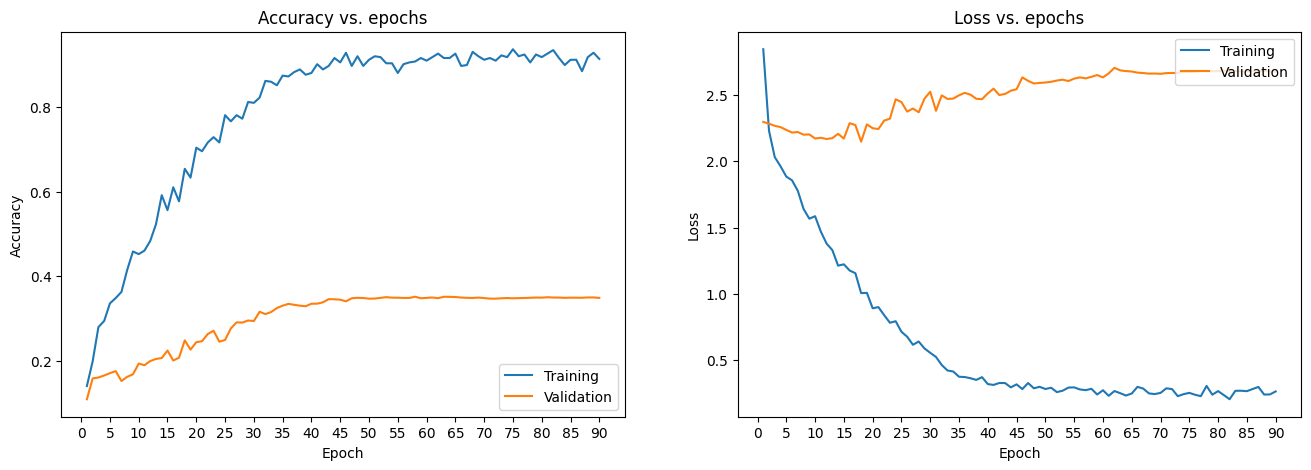

2022-08-16 09:50:28,632: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 09:50:32,694: INFO: test loss:2.6365
2022-08-16 09:50:32,694: INFO: test accuracy:0.3511
2022-08-16 09:50:32,696: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-16 09:50:32,697: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-16 09:50:32,698: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator
2022-08-16 09:50:32,699: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator
2022-08-16 09:50:32,700: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:50:33,040: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator


313/313 [==============================] - 1s 2ms/step


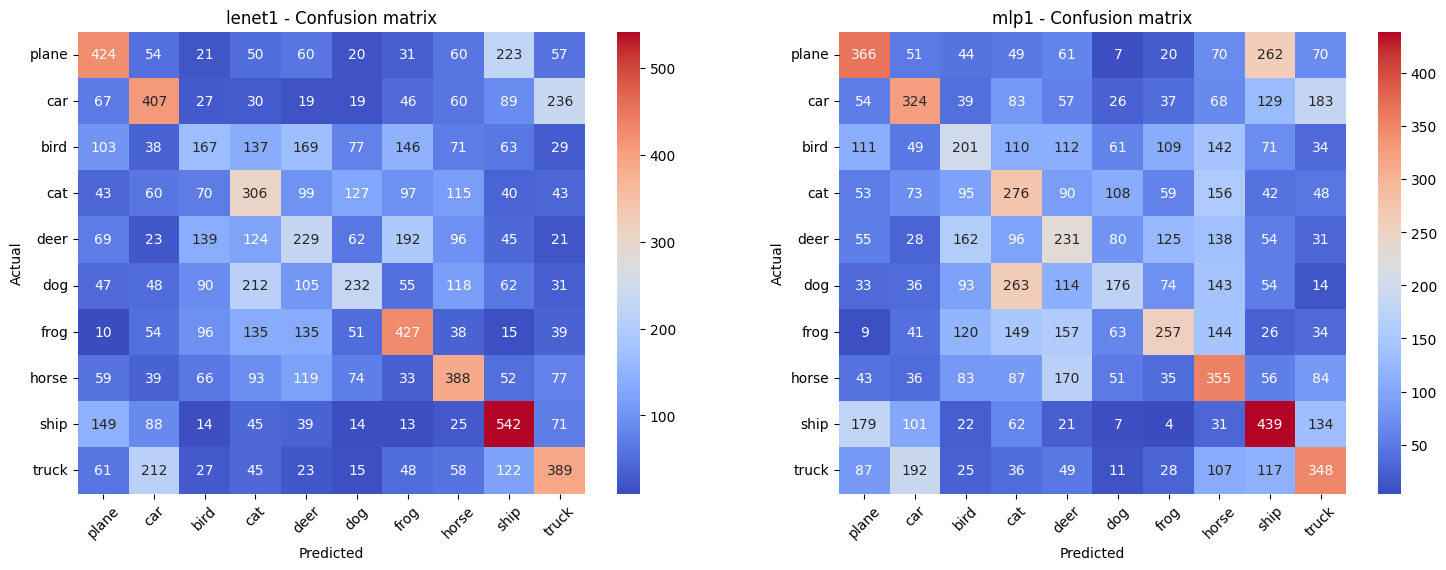

----------------------------------------models----------------------------------------


model_name               program_name  weight_number  train_time  \
1     lenet1  cifar10_0816_cnt_50.ipynb          83170       175.8   
2       mlp1  cifar10_0816_cnt_50.ipynb         394634        86.5   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:50      0.1424     2.6365           0.962         0.3511   
2  2022-08-16 09:47      1.2401     2.0180           0.646         0.2973   

   train_auc  test_auc  
1     0.9979    0.7828  
2     0.9260    0.7458

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


2022-08-16 09:50:36,653: INFO: model_params.custom1.dropout=0.2
2022-08-16 09:50:36,789: INFO: learning_rate=0.001
2022-08-16 09:50:36,789: INFO: model_params.custom1.clip_value=None
2022-08-16 09:50:36,795: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0   

2022-08-16 09:50:36,827: INFO: model_params.custom1.epochs=90
2022-08-16 09:50:36,828: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1, monitor=val_accuracy)
2022-08-16 09:50:36,828: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:50:36,829: INFO: use LearningRateScheduler()
2022-08-16 09:50:36,829: INFO: steps_per_epoch=15
2022-08-16 09:50:36,830: INFO: start training
2022-08-16 09:50:36,831: INFO: use_class_weight=False


Epoch 1/90
15/15 [==============================] - ETA: 0s - loss: 3.1049 - accuracy: 0.1125

2022-08-16 09:50:43,476: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:50:44,160: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 7s 435ms/step - loss: 3.1049 - accuracy: 0.1125 - val_loss: 2.3000 - val_accuracy: 0.0994 - lr: 0.0010
Epoch 2/90
13/15 [=========================>....] - ETA: 0s - loss: 2.2940 - accuracy: 0.2091

2022-08-16 09:50:48,791: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:50:49,473: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 5s 377ms/step - loss: 2.2541 - accuracy: 0.2271 - val_loss: 2.2958 - val_accuracy: 0.1323 - lr: 0.0010
Epoch 3/90
15/15 [==============================] - 3s 209ms/step - loss: 2.0595 - accuracy: 0.3000 - val_loss: 2.3567 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 4/90
15/15 [==============================] - 2s 108ms/step - loss: 1.9601 - accuracy: 0.3229 - val_loss: 2.4660 - val_accuracy: 0.1235 - lr: 0.0010
Epoch 5/90
13/15 [=========================>....] - ETA: 0s - loss: 1.7945 - accuracy: 0.3678

2022-08-16 09:50:57,234: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:50:57,905: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 279ms/step - loss: 1.7743 - accuracy: 0.3792 - val_loss: 2.6119 - val_accuracy: 0.1373 - lr: 0.0010
Epoch 6/90
15/15 [==============================] - 2s 138ms/step - loss: 1.6897 - accuracy: 0.4000 - val_loss: 2.7557 - val_accuracy: 0.1001 - lr: 0.0010
Epoch 7/90
15/15 [==============================] - 2s 138ms/step - loss: 1.6260 - accuracy: 0.4313 - val_loss: 2.8551 - val_accuracy: 0.0994 - lr: 0.0010
Epoch 8/90
15/15 [==============================] - 2s 109ms/step - loss: 1.5657 - accuracy: 0.4250 - val_loss: 2.9282 - val_accuracy: 0.0999 - lr: 0.0010
Epoch 9/90
15/15 [==============================] - 2s 110ms/step - loss: 1.4762 - accuracy: 0.4854 - val_loss: 3.0800 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 10/90
15/15 [==============================] - 2s 110ms/step - loss: 1.4217 - accuracy: 0.4771 - val_loss: 3.1866 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 11/90
15/15 [==============================] - 2s 112ms/step - loss: 1.396

2022-08-16 09:51:41,652: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:51:42,326: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 6s 407ms/step - loss: 0.8564 - accuracy: 0.7125 - val_loss: 3.1476 - val_accuracy: 0.1441 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/90
15/15 [==============================] - 3s 222ms/step - loss: 0.8076 - accuracy: 0.7458 - val_loss: 3.1924 - val_accuracy: 0.1434 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/90
14/15 [===========================>..] - ETA: 0s - loss: 0.8263 - accuracy: 0.7076

2022-08-16 09:51:49,900: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:51:50,569: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 5s 361ms/step - loss: 0.8088 - accuracy: 0.7146 - val_loss: 3.0780 - val_accuracy: 0.1520 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/90
15/15 [==============================] - ETA: 0s - loss: 0.7877 - accuracy: 0.7312

2022-08-16 09:51:54,008: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:51:54,944: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 312ms/step - loss: 0.7877 - accuracy: 0.7312 - val_loss: 3.0407 - val_accuracy: 0.1538 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/90
14/15 [===========================>..] - ETA: 0s - loss: 0.7309 - accuracy: 0.7589

2022-08-16 09:51:58,068: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:51:58,747: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 269ms/step - loss: 0.7263 - accuracy: 0.7563 - val_loss: 2.8651 - val_accuracy: 0.1783 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
11/15 [=====================>........] - ETA: 0s - loss: 0.6975 - accuracy: 0.7415

2022-08-16 09:52:01,063: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:01,729: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 212ms/step - loss: 0.7081 - accuracy: 0.7375 - val_loss: 2.8607 - val_accuracy: 0.1806 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
13/15 [=========================>....] - ETA: 0s - loss: 0.7531 - accuracy: 0.7380

2022-08-16 09:52:04,316: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:05,003: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 234ms/step - loss: 0.7542 - accuracy: 0.7417 - val_loss: 2.7795 - val_accuracy: 0.1940 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
15/15 [==============================] - 1s 59ms/step - loss: 0.6954 - accuracy: 0.7833 - val_loss: 2.8035 - val_accuracy: 0.1940 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
12/15 [=======================>......] - ETA: 0s - loss: 0.6381 - accuracy: 0.7917

2022-08-16 09:52:08,172: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:08,844: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 213ms/step - loss: 0.6492 - accuracy: 0.7896 - val_loss: 2.7576 - val_accuracy: 0.2056 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
12/15 [=======================>......] - ETA: 0s - loss: 0.6109 - accuracy: 0.7891

2022-08-16 09:52:11,244: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:11,945: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
15/15 [==============================] - 3s 223ms/step - loss: 0.6215 - accuracy: 0.7896 - val_loss: 2.5731 - val_accuracy: 0.2292 - lr: 1.0000e-04
Epoch 00033: Still keep learning rate 0.0001 instead of 0.001
Epoch 33/90
12/15 [=======================>......] - ETA: 0s - loss: 0.6445 - accuracy: 0.7865

2022-08-16 09:52:15,341: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:16,031: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 289ms/step - loss: 0.6484 - accuracy: 0.7875 - val_loss: 2.4749 - val_accuracy: 0.2441 - lr: 1.0000e-04
Epoch 00034: Still keep learning rate 0.0001 instead of 0.001
Epoch 34/90
11/15 [=====================>........] - ETA: 0s - loss: 0.5959 - accuracy: 0.7955

2022-08-16 09:52:19,514: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:20,199: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 295ms/step - loss: 0.6135 - accuracy: 0.7896 - val_loss: 2.3955 - val_accuracy: 0.2605 - lr: 1.0000e-04
Epoch 00035: Still keep learning rate 0.0001 instead of 0.001
Epoch 35/90
15/15 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.7729

2022-08-16 09:52:24,033: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:24,703: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 319ms/step - loss: 0.6205 - accuracy: 0.7729 - val_loss: 2.3309 - val_accuracy: 0.2736 - lr: 1.0000e-04
Epoch 00036: Still keep learning rate 0.0001 instead of 0.001
Epoch 36/90
12/15 [=======================>......] - ETA: 0s - loss: 0.5938 - accuracy: 0.8203

2022-08-16 09:52:28,069: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:28,770: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 289ms/step - loss: 0.5878 - accuracy: 0.8250 - val_loss: 2.2960 - val_accuracy: 0.2842 - lr: 1.0000e-04
Epoch 00037: Still keep learning rate 0.0001 instead of 0.001
Epoch 37/90
14/15 [===========================>..] - ETA: 0s - loss: 0.6222 - accuracy: 0.7857

2022-08-16 09:52:32,250: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:32,940: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 296ms/step - loss: 0.6208 - accuracy: 0.7833 - val_loss: 2.2457 - val_accuracy: 0.2960 - lr: 1.0000e-04
Epoch 00038: Still keep learning rate 0.0001 instead of 0.001
Epoch 38/90
14/15 [===========================>..] - ETA: 0s - loss: 0.6220 - accuracy: 0.7902

2022-08-16 09:52:35,640: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:36,349: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 243ms/step - loss: 0.6079 - accuracy: 0.7979 - val_loss: 2.1964 - val_accuracy: 0.3054 - lr: 1.0000e-04
Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/90
13/15 [=========================>....] - ETA: 0s - loss: 0.6019 - accuracy: 0.8101

2022-08-16 09:52:38,671: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:39,337: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 211ms/step - loss: 0.6115 - accuracy: 0.8083 - val_loss: 2.1667 - val_accuracy: 0.3179 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/90
13/15 [=========================>....] - ETA: 0s - loss: 0.6182 - accuracy: 0.7885

2022-08-16 09:52:41,623: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:42,283: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 209ms/step - loss: 0.6126 - accuracy: 0.7896 - val_loss: 2.1424 - val_accuracy: 0.3244 - lr: 1.0000e-04
Epoch 00041: Still keep learning rate 0.0001 instead of 0.001
Epoch 41/90
12/15 [=======================>......] - ETA: 0s - loss: 0.5525 - accuracy: 0.8125

2022-08-16 09:52:44,911: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:45,604: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 237ms/step - loss: 0.5761 - accuracy: 0.8000 - val_loss: 2.1242 - val_accuracy: 0.3331 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/90
11/15 [=====================>........] - ETA: 0s - loss: 0.5795 - accuracy: 0.8125

2022-08-16 09:52:48,686: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:49,361: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 266ms/step - loss: 0.5987 - accuracy: 0.8000 - val_loss: 2.1009 - val_accuracy: 0.3388 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/90
15/15 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.8188

2022-08-16 09:52:52,799: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:53,481: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 292ms/step - loss: 0.5662 - accuracy: 0.8188 - val_loss: 2.0708 - val_accuracy: 0.3446 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/90
15/15 [==============================] - 2s 115ms/step - loss: 0.5559 - accuracy: 0.7917 - val_loss: 2.0920 - val_accuracy: 0.3442 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/90
12/15 [=======================>......] - ETA: 0s - loss: 0.5508 - accuracy: 0.8516

2022-08-16 09:52:58,815: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:52:59,510: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 312ms/step - loss: 0.5351 - accuracy: 0.8562 - val_loss: 2.0763 - val_accuracy: 0.3493 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
13/15 [=========================>....] - ETA: 0s - loss: 0.5491 - accuracy: 0.8269

2022-08-16 09:53:02,951: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:53:03,631: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 292ms/step - loss: 0.5572 - accuracy: 0.8229 - val_loss: 2.0567 - val_accuracy: 0.3569 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
13/15 [=========================>....] - ETA: 0s - loss: 0.5886 - accuracy: 0.7788

2022-08-16 09:53:05,961: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:53:06,878: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 231ms/step - loss: 0.5969 - accuracy: 0.7792 - val_loss: 2.0438 - val_accuracy: 0.3668 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/90
13/15 [=========================>....] - ETA: 0s - loss: 0.5937 - accuracy: 0.7861

2022-08-16 09:53:09,216: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:53:09,894: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 215ms/step - loss: 0.5936 - accuracy: 0.7979 - val_loss: 2.0442 - val_accuracy: 0.3673 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/90
15/15 [==============================] - 2s 142ms/step - loss: 0.5336 - accuracy: 0.8250 - val_loss: 2.0252 - val_accuracy: 0.3673 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/90
15/15 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.8292

2022-08-16 09:53:15,238: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:53:15,926: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 285ms/step - loss: 0.5220 - accuracy: 0.8292 - val_loss: 2.0103 - val_accuracy: 0.3706 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/90
13/15 [=========================>....] - ETA: 0s - loss: 0.5743 - accuracy: 0.8101

2022-08-16 09:53:19,408: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:53:20,400: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 4s 318ms/step - loss: 0.5638 - accuracy: 0.8146 - val_loss: 2.0072 - val_accuracy: 0.3735 - lr: 1.0000e-04
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
Epoch 52/90
11/15 [=====================>........] - ETA: 0s - loss: 0.5711 - accuracy: 0.8011

2022-08-16 09:53:22,905: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:53:23,588: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 225ms/step - loss: 0.5679 - accuracy: 0.8021 - val_loss: 2.0051 - val_accuracy: 0.3760 - lr: 1.0000e-04
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
Epoch 53/90
15/15 [==============================] - 2s 122ms/step - loss: 0.5265 - accuracy: 0.8208 - val_loss: 2.0126 - val_accuracy: 0.3737 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/90
15/15 [==============================] - 2s 155ms/step - loss: 0.5029 - accuracy: 0.8417 - val_loss: 2.0225 - val_accuracy: 0.3753 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/90
15/15 [==============================] - 3s 229ms/step - loss: 0.5490 - accuracy: 0.8292 - val_loss: 2.0185 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/90
15/15 [==============================] - 4s 263ms/step - loss: 0.4704 - accuracy: 0.8521 - val_loss: 2.0277 - va

2022-08-16 09:53:38,571: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:53:39,259: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 5s 339ms/step - loss: 0.5402 - accuracy: 0.8021 - val_loss: 2.0315 - val_accuracy: 0.3763 - lr: 1.0000e-04
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
Epoch 58/90
12/15 [=======================>......] - ETA: 0s - loss: 0.4811 - accuracy: 0.8281

2022-08-16 09:53:45,001: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:53:45,739: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 7s 462ms/step - loss: 0.4945 - accuracy: 0.8167 - val_loss: 2.0168 - val_accuracy: 0.3807 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/90
15/15 [==============================] - 3s 247ms/step - loss: 0.5035 - accuracy: 0.8396 - val_loss: 2.0134 - val_accuracy: 0.3802 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/90
15/15 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8458

2022-08-16 09:53:53,497: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:53:54,178: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 5s 347ms/step - loss: 0.4609 - accuracy: 0.8458 - val_loss: 2.0215 - val_accuracy: 0.3823 - lr: 1.0000e-04
Epoch 61/90
15/15 [==============================] - 2s 138ms/step - loss: 0.4836 - accuracy: 0.8438 - val_loss: 2.0234 - val_accuracy: 0.3812 - lr: 1.0000e-04
Epoch 62/90
15/15 [==============================] - 1s 72ms/step - loss: 0.5158 - accuracy: 0.8250 - val_loss: 2.0274 - val_accuracy: 0.3804 - lr: 1.0000e-04
Epoch 63/90
15/15 [==============================] - 1s 59ms/step - loss: 0.4493 - accuracy: 0.8458 - val_loss: 2.0554 - val_accuracy: 0.3813 - lr: 1.0000e-04
Epoch 64/90
13/15 [=========================>....] - ETA: 0s - loss: 0.4547 - accuracy: 0.8534

2022-08-16 09:54:00,353: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:54:01,008: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 213ms/step - loss: 0.4607 - accuracy: 0.8500 - val_loss: 2.0440 - val_accuracy: 0.3836 - lr: 1.0000e-04
Epoch 65/90
12/15 [=======================>......] - ETA: 0s - loss: 0.4945 - accuracy: 0.8255

2022-08-16 09:54:03,615: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:54:04,292: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


15/15 [==============================] - 3s 234ms/step - loss: 0.5170 - accuracy: 0.8271 - val_loss: 2.0236 - val_accuracy: 0.3848 - lr: 1.0000e-04
Epoch 66/90
15/15 [==============================] - 1s 59ms/step - loss: 0.4941 - accuracy: 0.8354 - val_loss: 2.0180 - val_accuracy: 0.3838 - lr: 1.0000e-04
Epoch 67/90
13/15 [=========================>....] - ETA: 0s - loss: 0.5036 - accuracy: 0.8269

2022-08-16 09:54:07,462: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets


2022-08-16 09:54:08,146: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1/assets



Epoch 67: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
15/15 [==============================] - 3s 214ms/step - loss: 0.4823 - accuracy: 0.8333 - val_loss: 2.0175 - val_accuracy: 0.3855 - lr: 3.1623e-05
Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/90
15/15 [==============================] - 1s 59ms/step - loss: 0.4907 - accuracy: 0.8313 - val_loss: 2.0245 - val_accuracy: 0.3848 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/90
15/15 [==============================] - 1s 84ms/step - loss: 0.4262 - accuracy: 0.8542 - val_loss: 2.0335 - val_accuracy: 0.3839 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/90
15/15 [==============================] - 2s 120ms/step - loss: 0.4241 - accuracy: 0.8708 - val_loss: 2.0319 - val_accuracy: 0.3840 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/90
15/15 [================

2022-08-16 09:54:46,175: INFO: finish training [elapsed time: 249.35 seconds]


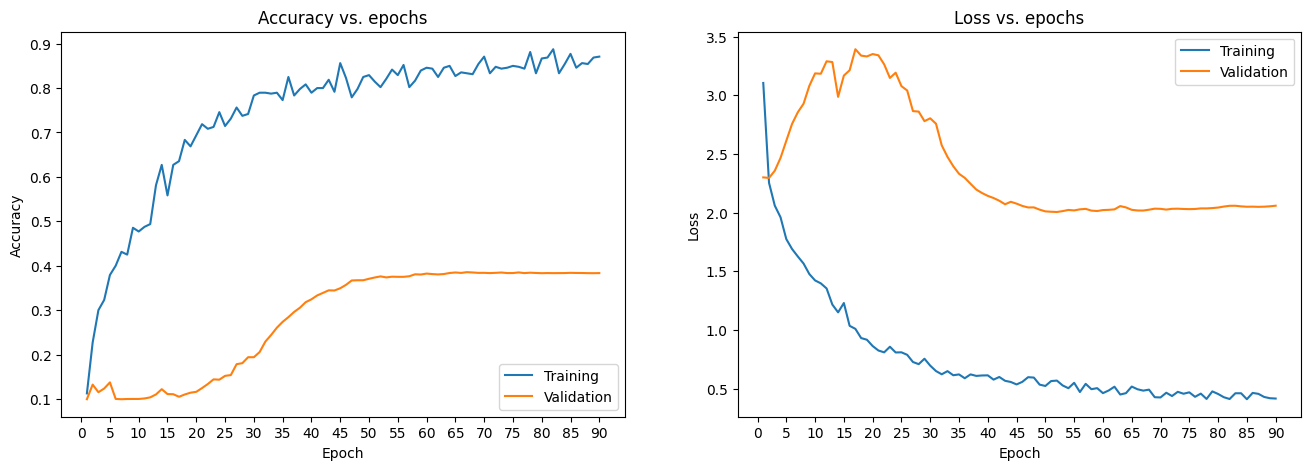

2022-08-16 09:54:46,613: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 09:54:50,228: INFO: test loss:2.0175
2022-08-16 09:54:50,229: INFO: test accuracy:0.3855
2022-08-16 09:54:50,230: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-16 09:54:50,232: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-16 09:54:50,232: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator
2022-08-16 09:54:50,234: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator
2022-08-16 09:54:50,234: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/lenet1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:54:51,395: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator


313/313 [==============================] - 1s 2ms/step


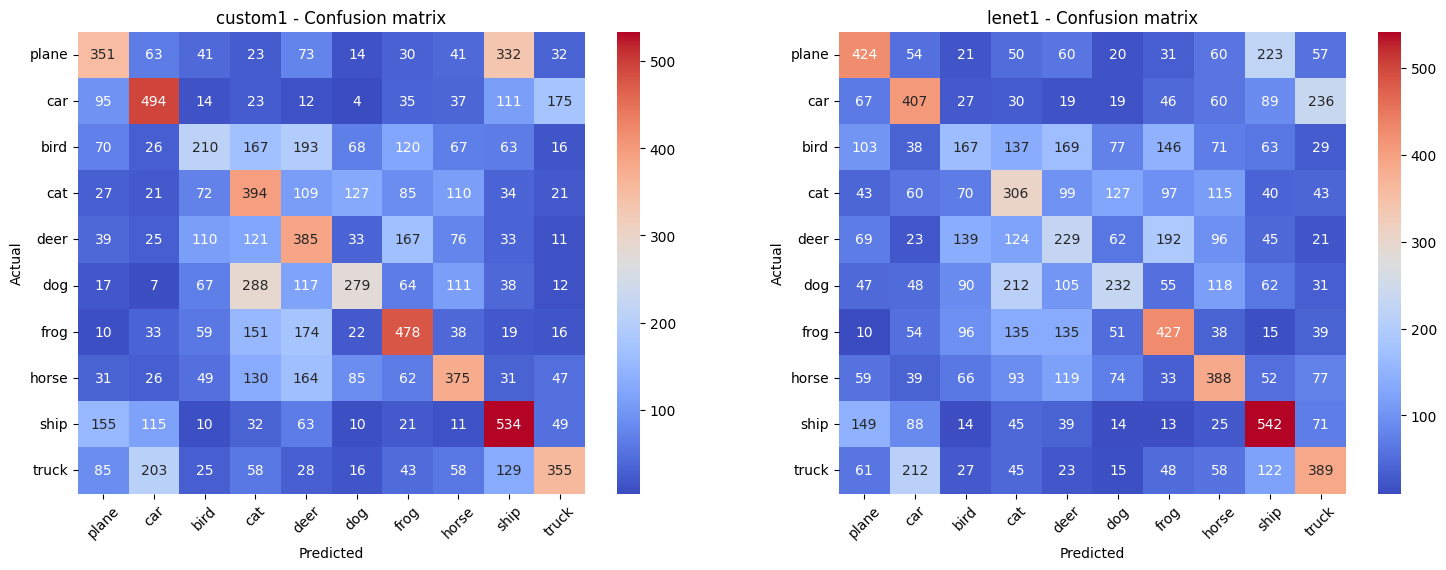

----------------------------------------models----------------------------------------


model_name               program_name  weight_number  train_time  \
1    custom1  cifar10_0816_cnt_50.ipynb          73738       249.3   
2     lenet1  cifar10_0816_cnt_50.ipynb          83170       175.8   
3       mlp1  cifar10_0816_cnt_50.ipynb         394634        86.5   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:54      0.2715     2.0175           0.952         0.3855   
2  2022-08-16 09:50      0.1424     2.6365           0.962         0.3511   
3  2022-08-16 09:47      1.2401     2.0180           0.646         0.2973   

   train_auc  test_auc  
1     0.9943    0.8181  
2     0.9979    0.7828  
3     0.9260    0.7458

In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [26]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

tf.Tensor(
[[187 218 244]
 [181 212 238]
 [178 211 240]
 [172 207 239]
 [173 208 240]], shape=(5, 3), dtype=uint8)
tf.Tensor(
[[0.73333335 0.854902   0.9568628 ]
 [0.70980394 0.8313726  0.9333334 ]
 [0.69803923 0.82745105 0.94117653]
 [0.6745098  0.8117648  0.93725497]
 [0.6784314  0.81568635 0.94117653]], shape=(5, 3), dtype=float32)


In [27]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


2022-08-16 09:54:55,105: INFO: model_params.vgg8.dropout=0.1
2022-08-16 09:54:55,301: INFO: learning_rate=0.001
2022-08-16 09:54:55,302: INFO: model_params.vgg8.clip_value=None
2022-08-16 09:54:55,309: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                              

2022-08-16 09:54:55,483: INFO: model_params.vgg8.epochs=90
2022-08-16 09:54:55,484: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8, monitor=val_accuracy)
2022-08-16 09:54:55,485: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:54:55,486: INFO: use LearningRateScheduler()
2022-08-16 09:54:55,487: INFO: steps_per_epoch=15
2022-08-16 09:54:55,488: INFO: start training
2022-08-16 09:54:55,489: INFO: use_class_weight=False


Epoch 1/90
15/15 [==============================] - ETA: 0s - loss: 4.5664 - accuracy: 0.1437

2022-08-16 09:55:02,623: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:55:04,024: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 9s 496ms/step - loss: 4.5664 - accuracy: 0.1437 - val_loss: 2.4231 - val_accuracy: 0.1098 - lr: 0.0010
Epoch 2/90
14/15 [===========================>..] - ETA: 0s - loss: 2.2607 - accuracy: 0.1853

2022-08-16 09:55:09,361: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:55:10,479: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 6s 457ms/step - loss: 2.2490 - accuracy: 0.1875 - val_loss: 2.3349 - val_accuracy: 0.1400 - lr: 0.0010
Epoch 3/90
15/15 [==============================] - 3s 203ms/step - loss: 2.0960 - accuracy: 0.2479 - val_loss: 2.4549 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/90
15/15 [==============================] - 3s 205ms/step - loss: 1.9070 - accuracy: 0.3187 - val_loss: 2.6049 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/90
15/15 [==============================] - 2s 113ms/step - loss: 1.7818 - accuracy: 0.3688 - val_loss: 2.8367 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/90
15/15 [==============================] - 1s 95ms/step - loss: 1.6783 - accuracy: 0.3854 - val_loss: 2.9341 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 7/90
15/15 [==============================] - 1s 95ms/step - loss: 1.6061 - accuracy: 0.4187 - val_loss: 3.0595 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 8/90
15/15 [==============================] - 1s 96ms/step - loss: 1.4758 - a

2022-08-16 09:55:50,826: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:55:51,902: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 358ms/step - loss: 0.1465 - accuracy: 0.9750 - val_loss: 3.4961 - val_accuracy: 0.1546 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/90
12/15 [=======================>......] - ETA: 0s - loss: 0.1319 - accuracy: 0.9688

2022-08-16 09:55:56,220: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:55:57,317: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 385ms/step - loss: 0.1313 - accuracy: 0.9688 - val_loss: 3.6306 - val_accuracy: 0.1591 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/90
15/15 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9750

2022-08-16 09:56:02,714: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:03,815: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 7s 463ms/step - loss: 0.1197 - accuracy: 0.9750 - val_loss: 3.3156 - val_accuracy: 0.1754 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/90
15/15 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9708

2022-08-16 09:56:09,041: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:10,114: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 6s 445ms/step - loss: 0.1215 - accuracy: 0.9708 - val_loss: 3.5053 - val_accuracy: 0.1789 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
15/15 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9750

2022-08-16 09:56:15,740: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:16,879: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 7s 481ms/step - loss: 0.1142 - accuracy: 0.9750 - val_loss: 3.3063 - val_accuracy: 0.1913 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1039 - accuracy: 0.9808

2022-08-16 09:56:20,487: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:21,778: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 348ms/step - loss: 0.1066 - accuracy: 0.9792 - val_loss: 3.3894 - val_accuracy: 0.2103 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1072 - accuracy: 0.9760

2022-08-16 09:56:25,365: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:26,394: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 328ms/step - loss: 0.1066 - accuracy: 0.9729 - val_loss: 3.2890 - val_accuracy: 0.2281 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
12/15 [=======================>......] - ETA: 0s - loss: 0.1265 - accuracy: 0.9688

2022-08-16 09:56:29,990: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:31,353: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 354ms/step - loss: 0.1130 - accuracy: 0.9729 - val_loss: 3.1761 - val_accuracy: 0.2384 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
13/15 [=========================>....] - ETA: 0s - loss: 0.0699 - accuracy: 0.9904

2022-08-16 09:56:35,009: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:36,105: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
15/15 [==============================] - 5s 338ms/step - loss: 0.0690 - accuracy: 0.9917 - val_loss: 2.9717 - val_accuracy: 0.2594 - lr: 1.0000e-04
Epoch 00033: Still keep learning rate 0.0001 instead of 0.001
Epoch 33/90
13/15 [=========================>....] - ETA: 0s - loss: 0.0892 - accuracy: 0.9736

2022-08-16 09:56:39,826: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:41,250: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 368ms/step - loss: 0.0881 - accuracy: 0.9750 - val_loss: 2.9434 - val_accuracy: 0.2695 - lr: 1.0000e-04
Epoch 00034: Still keep learning rate 0.0001 instead of 0.001
Epoch 34/90
13/15 [=========================>....] - ETA: 0s - loss: 0.0845 - accuracy: 0.9736

2022-08-16 09:56:44,978: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:46,049: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 340ms/step - loss: 0.0869 - accuracy: 0.9729 - val_loss: 2.9483 - val_accuracy: 0.2757 - lr: 1.0000e-04
Epoch 00035: Still keep learning rate 0.0001 instead of 0.001
Epoch 35/90
13/15 [=========================>....] - ETA: 0s - loss: 0.0679 - accuracy: 0.9856

2022-08-16 09:56:50,068: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:51,200: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 367ms/step - loss: 0.0656 - accuracy: 0.9854 - val_loss: 2.7850 - val_accuracy: 0.2943 - lr: 1.0000e-04
Epoch 00036: Still keep learning rate 0.0001 instead of 0.001
Epoch 36/90
13/15 [=========================>....] - ETA: 0s - loss: 0.0677 - accuracy: 0.9904

2022-08-16 09:56:55,005: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:56:56,143: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 351ms/step - loss: 0.0663 - accuracy: 0.9917 - val_loss: 2.7074 - val_accuracy: 0.3172 - lr: 1.0000e-04
Epoch 00037: Still keep learning rate 0.0001 instead of 0.001
Epoch 37/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0767 - accuracy: 0.9801

2022-08-16 09:57:00,376: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:01,580: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 388ms/step - loss: 0.0770 - accuracy: 0.9812 - val_loss: 2.6074 - val_accuracy: 0.3384 - lr: 1.0000e-04
Epoch 00038: Still keep learning rate 0.0001 instead of 0.001
Epoch 38/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0775 - accuracy: 0.9858

2022-08-16 09:57:05,439: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:06,550: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 352ms/step - loss: 0.0824 - accuracy: 0.9812 - val_loss: 2.5760 - val_accuracy: 0.3478 - lr: 1.0000e-04
Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0713 - accuracy: 0.9858

2022-08-16 09:57:10,765: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:11,925: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 383ms/step - loss: 0.0706 - accuracy: 0.9854 - val_loss: 2.4919 - val_accuracy: 0.3625 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0660 - accuracy: 0.9886

2022-08-16 09:57:15,752: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:17,151: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 373ms/step - loss: 0.0581 - accuracy: 0.9917 - val_loss: 2.4832 - val_accuracy: 0.3689 - lr: 1.0000e-04
Epoch 00041: Still keep learning rate 0.0001 instead of 0.001
Epoch 41/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0794 - accuracy: 0.9773

2022-08-16 09:57:21,072: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:22,222: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 359ms/step - loss: 0.0788 - accuracy: 0.9771 - val_loss: 2.5045 - val_accuracy: 0.3703 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0598 - accuracy: 0.9858

2022-08-16 09:57:26,044: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:27,573: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 382ms/step - loss: 0.0577 - accuracy: 0.9896 - val_loss: 2.4419 - val_accuracy: 0.3763 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0650 - accuracy: 0.9830

2022-08-16 09:57:31,526: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:32,707: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 365ms/step - loss: 0.0616 - accuracy: 0.9875 - val_loss: 2.4605 - val_accuracy: 0.3852 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0646 - accuracy: 0.9830

2022-08-16 09:57:36,952: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:38,146: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 390ms/step - loss: 0.0613 - accuracy: 0.9854 - val_loss: 2.4442 - val_accuracy: 0.3878 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0516 - accuracy: 0.9858

2022-08-16 09:57:42,198: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:43,363: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 367ms/step - loss: 0.0522 - accuracy: 0.9875 - val_loss: 2.4588 - val_accuracy: 0.3897 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
13/15 [=========================>....] - ETA: 0s - loss: 0.0781 - accuracy: 0.9760

2022-08-16 09:57:47,555: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:48,801: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 392ms/step - loss: 0.0734 - accuracy: 0.9792 - val_loss: 2.4009 - val_accuracy: 0.4047 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0503 - accuracy: 0.9943

2022-08-16 09:57:52,758: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:57:53,932: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets



Epoch 47: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
15/15 [==============================] - 5s 361ms/step - loss: 0.0545 - accuracy: 0.9917 - val_loss: 2.3865 - val_accuracy: 0.4086 - lr: 3.1623e-05
Epoch 00048: LearningRateScheduler reducing learning rate to 0.001 from 3.16e-05.
Epoch 48/90
15/15 [==============================] - 1s 98ms/step - loss: 0.0874 - accuracy: 0.9812 - val_loss: 2.4330 - val_accuracy: 0.3874 - lr: 0.0010
Epoch 49/90
15/15 [==============================] - 1s 98ms/step - loss: 0.1935 - accuracy: 0.9458 - val_loss: 3.7169 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 50/90
15/15 [==============================] - 1s 98ms/step - loss: 0.4366 - accuracy: 0.8583 - val_loss: 6.0870 - val_accuracy: 0.2600 - lr: 0.0010
Epoch 51/90
15/15 [==============================] - 1s 99ms/step - loss: 0.6582 - accuracy: 0.7646 - val_loss: 6.0464 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 52/90
15/15 [==============================] - 1s 99ms/step - los

2022-08-16 09:58:20,424: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:58:21,571: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 383ms/step - loss: 0.0600 - accuracy: 0.9854 - val_loss: 2.9582 - val_accuracy: 0.4092 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0453 - accuracy: 0.9830

2022-08-16 09:58:25,511: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:58:26,656: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 362ms/step - loss: 0.0420 - accuracy: 0.9854 - val_loss: 2.9272 - val_accuracy: 0.4112 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0479 - accuracy: 0.9886

2022-08-16 09:58:30,952: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:58:32,105: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 387ms/step - loss: 0.0467 - accuracy: 0.9875 - val_loss: 2.9017 - val_accuracy: 0.4133 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0556 - accuracy: 0.9830

2022-08-16 09:58:36,093: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:58:37,535: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 387ms/step - loss: 0.0539 - accuracy: 0.9792 - val_loss: 2.8828 - val_accuracy: 0.4137 - lr: 3.1623e-05
Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0577 - accuracy: 0.9830

2022-08-16 09:58:41,593: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:58:42,788: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 373ms/step - loss: 0.0503 - accuracy: 0.9854 - val_loss: 2.8676 - val_accuracy: 0.4144 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0384 - accuracy: 0.9886

2022-08-16 09:58:47,021: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:58:48,211: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 387ms/step - loss: 0.0406 - accuracy: 0.9896 - val_loss: 2.8593 - val_accuracy: 0.4160 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0445 - accuracy: 0.9858

2022-08-16 09:58:52,137: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:58:53,332: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 363ms/step - loss: 0.0393 - accuracy: 0.9896 - val_loss: 2.8468 - val_accuracy: 0.4170 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/90
11/15 [=====================>........] - ETA: 0s - loss: 0.0365 - accuracy: 0.9886

2022-08-16 09:58:57,524: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:58:58,774: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


15/15 [==============================] - 5s 388ms/step - loss: 0.0354 - accuracy: 0.9917 - val_loss: 2.8397 - val_accuracy: 0.4176 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/90
15/15 [==============================] - 1s 99ms/step - loss: 0.0505 - accuracy: 0.9896 - val_loss: 2.8366 - val_accuracy: 0.4169 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/90
15/15 [==============================] - 1s 98ms/step - loss: 0.0541 - accuracy: 0.9792 - val_loss: 2.8346 - val_accuracy: 0.4175 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/90
15/15 [==============================] - 1s 97ms/step - loss: 0.0443 - accuracy: 0.9854 - val_loss: 2.8328 - val_accuracy: 0.4158 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/90
15/15 [==============================] - 1s 97ms/step - loss: 0.0426 - accuracy: 0.9896 - val_loss: 2.8

2022-08-16 09:59:09,642: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets


2022-08-16 09:59:10,791: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8/assets



Epoch 77: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
15/15 [==============================] - 5s 360ms/step - loss: 0.0355 - accuracy: 0.9958 - val_loss: 2.8066 - val_accuracy: 0.4185 - lr: 1.0000e-05
Epoch 00078: Still keep learning rate 1e-05 instead of 0.0001
Epoch 78/90
15/15 [==============================] - 1s 105ms/step - loss: 0.0360 - accuracy: 0.9958 - val_loss: 2.8047 - val_accuracy: 0.4181 - lr: 1.0000e-05
Epoch 00079: Still keep learning rate 1e-05 instead of 0.0001
Epoch 79/90
15/15 [==============================] - 1s 98ms/step - loss: 0.0476 - accuracy: 0.9854 - val_loss: 2.8047 - val_accuracy: 0.4174 - lr: 1.0000e-05
Epoch 00080: Still keep learning rate 1e-05 instead of 0.0001
Epoch 80/90
15/15 [==============================] - 1s 99ms/step - loss: 0.0391 - accuracy: 0.9896 - val_loss: 2.8046 - val_accuracy: 0.4178 - lr: 1.0000e-05
Epoch 00081: Still keep learning rate 1e-05 instead of 0.0001
Epoch 81/90
15/15 [=============================

2022-08-16 09:59:29,127: INFO: finish training [elapsed time: 273.64 seconds]


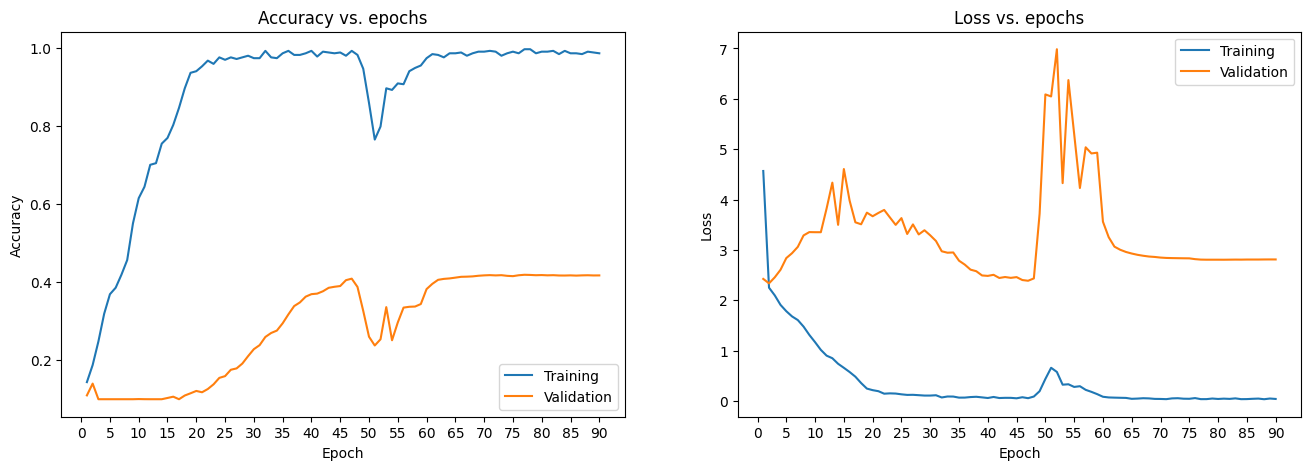

2022-08-16 09:59:29,561: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-16 09:59:35,136: INFO: test loss:2.8066
2022-08-16 09:59:35,137: INFO: test accuracy:0.4185
2022-08-16 09:59:35,139: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-16 09:59:35,141: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-16 09:59:35,142: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator
2022-08-16 09:59:35,143: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator
2022-08-16 09:59:35,143: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/custom1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:59:36,189: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator


313/313 [==============================] - 1s 2ms/step


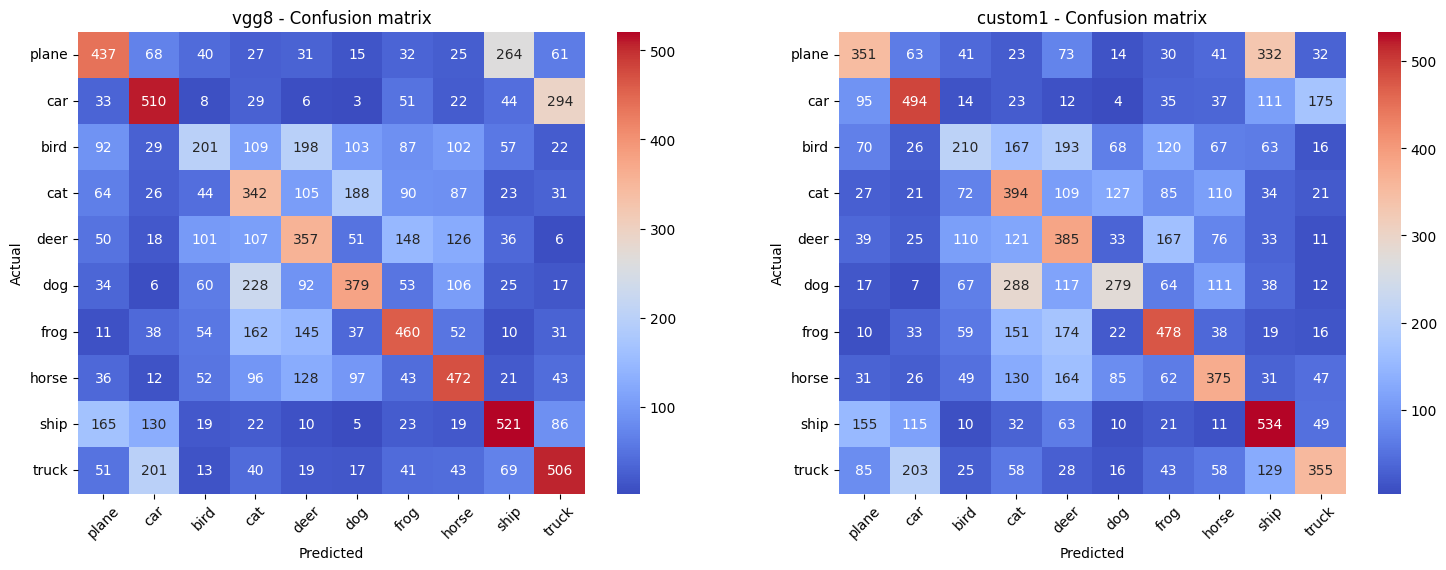

----------------------------------------models----------------------------------------


model_name               program_name  weight_number  train_time  \
1       vgg8  cifar10_0816_cnt_50.ipynb        1672906       273.6   
2    custom1  cifar10_0816_cnt_50.ipynb          73738       249.3   
3     lenet1  cifar10_0816_cnt_50.ipynb          83170       175.8   
4       mlp1  cifar10_0816_cnt_50.ipynb         394634        86.5   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:59      0.1492     2.8066           0.974         0.4185   
2  2022-08-16 09:54      0.2715     2.0175           0.952         0.3855   
3  2022-08-16 09:50      0.1424     2.6365           0.962         0.3511   
4  2022-08-16 09:47      1.2401     2.0180           0.646         0.2973   

   train_auc  test_auc  
1     0.9965    0.8281  
2     0.9943    0.8181  
3     0.9979    0.7828  
4     0.9260    0.7458

In [28]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-08-16 09:59:40,767: INFO: learning_rate=0.001
2022-08-16 09:59:40,768: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-16 09:59:40,775: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['rescaling[4][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                          

                                                                                                  
 conv2d_15 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_nor

 add_8 (Add)                    (None, 8, 8, 64)     0           ['activation_16[0][0]',          
                                                                  'batch_normalization_23[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (

2022-08-16 09:59:40,917: INFO: model_params.resnet_v1_20.epochs=90
2022-08-16 09:59:40,918: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20, monitor=val_accuracy)
2022-08-16 09:59:40,919: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:59:40,919: INFO: use LearningRateScheduler()
2022-08-16 09:59:40,920: INFO: steps_per_epoch=15
2022-08-16 09:59:40,921: INFO: start training
2022-08-16 09:59:40,921: INFO: use_class_weight=False


Epoch 1/90
13/15 [=========================>....] - ETA: 0s - loss: 2.8987 - accuracy: 0.1466

2022-08-16 09:59:54,817: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 09:59:57,914: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 17s 974ms/step - loss: 2.8242 - accuracy: 0.1542 - val_loss: 16.6851 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/90
15/15 [==============================] - 2s 168ms/step - loss: 1.9542 - accuracy: 0.3583 - val_loss: 5.1170 - val_accuracy: 0.0928 - lr: 0.0010
Epoch 3/90
13/15 [=========================>....] - ETA: 0s - loss: 1.5548 - accuracy: 0.5577

2022-08-16 10:00:10,266: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:00:13,371: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 932ms/step - loss: 1.5415 - accuracy: 0.5562 - val_loss: 3.7812 - val_accuracy: 0.1121 - lr: 0.0010
Epoch 4/90
13/15 [=========================>....] - ETA: 0s - loss: 1.1418 - accuracy: 0.7524

2022-08-16 10:00:23,288: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:00:26,624: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 942ms/step - loss: 1.1283 - accuracy: 0.7542 - val_loss: 3.3506 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 5/90
15/15 [==============================] - 2s 165ms/step - loss: 0.7931 - accuracy: 0.8646 - val_loss: 3.7934 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 6/90
15/15 [==============================] - 2s 166ms/step - loss: 0.6065 - accuracy: 0.9125 - val_loss: 3.8287 - val_accuracy: 0.1424 - lr: 0.0010
Epoch 7/90
13/15 [=========================>....] - ETA: 0s - loss: 0.4194 - accuracy: 0.9567

2022-08-16 10:00:41,513: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:00:44,702: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 956ms/step - loss: 0.4060 - accuracy: 0.9625 - val_loss: 4.1715 - val_accuracy: 0.1501 - lr: 0.0010
Epoch 8/90
13/15 [=========================>....] - ETA: 0s - loss: 0.2949 - accuracy: 0.9808

2022-08-16 10:00:54,718: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:00:57,841: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 934ms/step - loss: 0.2953 - accuracy: 0.9771 - val_loss: 3.9678 - val_accuracy: 0.1653 - lr: 0.0010
Epoch 9/90
13/15 [=========================>....] - ETA: 0s - loss: 0.2710 - accuracy: 0.9760

2022-08-16 10:01:07,653: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:01:11,041: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 941ms/step - loss: 0.2628 - accuracy: 0.9792 - val_loss: 4.3561 - val_accuracy: 0.1689 - lr: 0.0010
Epoch 10/90
15/15 [==============================] - 2s 166ms/step - loss: 0.2353 - accuracy: 0.9875 - val_loss: 4.1454 - val_accuracy: 0.1671 - lr: 0.0010
Epoch 11/90
15/15 [==============================] - 2s 167ms/step - loss: 0.2284 - accuracy: 0.9896 - val_loss: 4.8268 - val_accuracy: 0.1636 - lr: 0.0010
Epoch 12/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1975 - accuracy: 0.9928

2022-08-16 10:01:25,841: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:01:29,020: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 950ms/step - loss: 0.1950 - accuracy: 0.9937 - val_loss: 3.4747 - val_accuracy: 0.2206 - lr: 0.0010
Epoch 13/90
15/15 [==============================] - 2s 164ms/step - loss: 0.1754 - accuracy: 1.0000 - val_loss: 3.6059 - val_accuracy: 0.2181 - lr: 0.0010
Epoch 14/90
15/15 [==============================] - 2s 164ms/step - loss: 0.1658 - accuracy: 1.0000 - val_loss: 3.4984 - val_accuracy: 0.2179 - lr: 0.0010
Epoch 15/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1627 - accuracy: 1.0000

2022-08-16 10:01:43,781: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:01:46,907: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 939ms/step - loss: 0.1626 - accuracy: 1.0000 - val_loss: 3.3722 - val_accuracy: 0.2229 - lr: 0.0010
Epoch 16/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1613 - accuracy: 1.0000

2022-08-16 10:01:56,920: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:02:00,307: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 954ms/step - loss: 0.1612 - accuracy: 1.0000 - val_loss: 3.2896 - val_accuracy: 0.2277 - lr: 0.0010
Epoch 17/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1604 - accuracy: 1.0000

2022-08-16 10:02:09,833: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:02:13,536: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 947ms/step - loss: 0.1604 - accuracy: 1.0000 - val_loss: 3.2456 - val_accuracy: 0.2323 - lr: 0.0010
Epoch 18/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1597 - accuracy: 1.0000

2022-08-16 10:02:23,459: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:02:26,579: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 926ms/step - loss: 0.1597 - accuracy: 1.0000 - val_loss: 3.2198 - val_accuracy: 0.2365 - lr: 0.0010
Epoch 19/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1591 - accuracy: 1.0000

2022-08-16 10:02:36,409: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:02:39,548: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 924ms/step - loss: 0.1591 - accuracy: 1.0000 - val_loss: 3.1992 - val_accuracy: 0.2423 - lr: 0.0010
Epoch 20/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1586 - accuracy: 1.0000

2022-08-16 10:02:49,726: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:02:52,818: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 944ms/step - loss: 0.1585 - accuracy: 1.0000 - val_loss: 3.1793 - val_accuracy: 0.2473 - lr: 0.0010
Epoch 21/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1580 - accuracy: 1.0000

2022-08-16 10:03:02,686: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:03:05,998: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 939ms/step - loss: 0.1580 - accuracy: 1.0000 - val_loss: 3.1612 - val_accuracy: 0.2493 - lr: 0.0010
Epoch 22/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1575 - accuracy: 1.0000

2022-08-16 10:03:15,896: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:03:19,141: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 938ms/step - loss: 0.1575 - accuracy: 1.0000 - val_loss: 3.1428 - val_accuracy: 0.2528 - lr: 0.0010
Epoch 23/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1570 - accuracy: 1.0000

2022-08-16 10:03:29,102: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:03:32,218: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 932ms/step - loss: 0.1570 - accuracy: 1.0000 - val_loss: 3.1273 - val_accuracy: 0.2552 - lr: 0.0010
Epoch 24/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1565 - accuracy: 1.0000

2022-08-16 10:03:42,123: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:03:45,546: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 949ms/step - loss: 0.1565 - accuracy: 1.0000 - val_loss: 3.1132 - val_accuracy: 0.2555 - lr: 0.0010
Epoch 25/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1561 - accuracy: 1.0000

2022-08-16 10:03:55,484: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:03:58,605: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 931ms/step - loss: 0.1560 - accuracy: 1.0000 - val_loss: 3.1007 - val_accuracy: 0.2598 - lr: 0.0010
Epoch 26/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1556 - accuracy: 1.0000

2022-08-16 10:04:08,669: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:04:11,847: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 943ms/step - loss: 0.1555 - accuracy: 1.0000 - val_loss: 3.0910 - val_accuracy: 0.2621 - lr: 0.0010
Epoch 27/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1551 - accuracy: 1.0000

2022-08-16 10:04:21,766: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:04:25,111: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 945ms/step - loss: 0.1551 - accuracy: 1.0000 - val_loss: 3.0838 - val_accuracy: 0.2639 - lr: 0.0010
Epoch 28/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1546 - accuracy: 1.0000

2022-08-16 10:04:34,676: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:04:38,325: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 943ms/step - loss: 0.1546 - accuracy: 1.0000 - val_loss: 3.0785 - val_accuracy: 0.2665 - lr: 0.0010
Epoch 29/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1542 - accuracy: 1.0000

2022-08-16 10:04:48,441: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:04:51,595: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 945ms/step - loss: 0.1541 - accuracy: 1.0000 - val_loss: 3.0744 - val_accuracy: 0.2684 - lr: 0.0010
Epoch 30/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1537 - accuracy: 1.0000

2022-08-16 10:05:01,609: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:05:04,737: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 935ms/step - loss: 0.1536 - accuracy: 1.0000 - val_loss: 3.0719 - val_accuracy: 0.2697 - lr: 0.0010
Epoch 31/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1532 - accuracy: 1.0000

2022-08-16 10:05:14,629: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:05:17,991: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 944ms/step - loss: 0.1532 - accuracy: 1.0000 - val_loss: 3.0709 - val_accuracy: 0.2736 - lr: 0.0010
Epoch 32/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1527 - accuracy: 1.0000

2022-08-16 10:05:27,520: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:05:31,166: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 941ms/step - loss: 0.1527 - accuracy: 1.0000 - val_loss: 3.0709 - val_accuracy: 0.2757 - lr: 0.0010
Epoch 33/90
15/15 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 1.0000

2022-08-16 10:05:41,277: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:05:44,432: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 946ms/step - loss: 0.1522 - accuracy: 1.0000 - val_loss: 3.0716 - val_accuracy: 0.2776 - lr: 0.0010
Epoch 34/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1518 - accuracy: 1.0000

2022-08-16 10:05:54,594: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:05:57,716: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 947ms/step - loss: 0.1517 - accuracy: 1.0000 - val_loss: 3.0731 - val_accuracy: 0.2791 - lr: 0.0010
Epoch 35/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1513 - accuracy: 1.0000

2022-08-16 10:06:07,950: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:06:11,350: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 14s 967ms/step - loss: 0.1512 - accuracy: 1.0000 - val_loss: 3.0753 - val_accuracy: 0.2797 - lr: 0.0010
Epoch 36/90
15/15 [==============================] - 2s 170ms/step - loss: 0.1507 - accuracy: 1.0000 - val_loss: 3.0777 - val_accuracy: 0.2793 - lr: 0.0010
Epoch 37/90
15/15 [==============================] - 2s 167ms/step - loss: 0.1503 - accuracy: 1.0000 - val_loss: 3.0802 - val_accuracy: 0.2795 - lr: 0.0010
Epoch 38/90
15/15 [==============================] - 2s 170ms/step - loss: 0.1498 - accuracy: 1.0000 - val_loss: 3.0827 - val_accuracy: 0.2794 - lr: 0.0010
Epoch 39/90
15/15 [==============================] - 2s 168ms/step - loss: 0.1493 - accuracy: 1.0000 - val_loss: 3.0854 - val_accuracy: 0.2797 - lr: 0.0010
Epoch 40/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1488 - accuracy: 1.0000

2022-08-16 10:06:30,840: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:06:33,916: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 931ms/step - loss: 0.1488 - accuracy: 1.0000 - val_loss: 3.0881 - val_accuracy: 0.2802 - lr: 0.0010
Epoch 41/90
15/15 [==============================] - 2s 167ms/step - loss: 0.1483 - accuracy: 1.0000 - val_loss: 3.0907 - val_accuracy: 0.2801 - lr: 0.0010
Epoch 42/90
15/15 [==============================] - 2s 174ms/step - loss: 0.1477 - accuracy: 1.0000 - val_loss: 3.0932 - val_accuracy: 0.2799 - lr: 0.0010
Epoch 43/90
15/15 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 1.0000

2022-08-16 10:06:48,912: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:06:52,020: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 941ms/step - loss: 0.1472 - accuracy: 1.0000 - val_loss: 3.0958 - val_accuracy: 0.2806 - lr: 0.0010
Epoch 44/90
15/15 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 1.0000

2022-08-16 10:07:02,063: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:07:05,461: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 957ms/step - loss: 0.1467 - accuracy: 1.0000 - val_loss: 3.0983 - val_accuracy: 0.2808 - lr: 0.0010
Epoch 45/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1462 - accuracy: 1.0000

2022-08-16 10:07:15,205: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:07:18,986: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 14s 967ms/step - loss: 0.1462 - accuracy: 1.0000 - val_loss: 3.1007 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 46/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1457 - accuracy: 1.0000

2022-08-16 10:07:29,099: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:07:32,405: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets



Epoch 46: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
15/15 [==============================] - 13s 955ms/step - loss: 0.1457 - accuracy: 1.0000 - val_loss: 3.1031 - val_accuracy: 0.2823 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1453 - accuracy: 1.0000

2022-08-16 10:07:42,609: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:07:45,765: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 951ms/step - loss: 0.1453 - accuracy: 1.0000 - val_loss: 3.1032 - val_accuracy: 0.2831 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1452 - accuracy: 1.0000

2022-08-16 10:07:55,801: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:07:59,179: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 955ms/step - loss: 0.1452 - accuracy: 1.0000 - val_loss: 3.1038 - val_accuracy: 0.2832 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1450 - accuracy: 1.0000

2022-08-16 10:08:08,845: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:08:12,521: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 954ms/step - loss: 0.1450 - accuracy: 1.0000 - val_loss: 3.1047 - val_accuracy: 0.2835 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1448 - accuracy: 1.0000

2022-08-16 10:08:22,615: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:08:25,772: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 947ms/step - loss: 0.1448 - accuracy: 1.0000 - val_loss: 3.1059 - val_accuracy: 0.2838 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1447 - accuracy: 1.0000

2022-08-16 10:08:35,933: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:08:39,071: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 942ms/step - loss: 0.1447 - accuracy: 1.0000 - val_loss: 3.1072 - val_accuracy: 0.2839 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1445 - accuracy: 1.0000

2022-08-16 10:08:49,276: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:08:52,650: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 14s 966ms/step - loss: 0.1445 - accuracy: 1.0000 - val_loss: 3.1087 - val_accuracy: 0.2843 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1443 - accuracy: 1.0000

2022-08-16 10:09:02,176: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:09:05,874: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 946ms/step - loss: 0.1443 - accuracy: 1.0000 - val_loss: 3.1102 - val_accuracy: 0.2844 - lr: 3.1623e-04
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
Epoch 54/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1441 - accuracy: 1.0000

2022-08-16 10:09:15,503: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:09:19,092: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 943ms/step - loss: 0.1441 - accuracy: 1.0000 - val_loss: 3.1117 - val_accuracy: 0.2849 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/90
15/15 [==============================] - 2s 175ms/step - loss: 0.1439 - accuracy: 1.0000 - val_loss: 3.1131 - val_accuracy: 0.2845 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/90
15/15 [==============================] - 2s 172ms/step - loss: 0.1438 - accuracy: 1.0000 - val_loss: 3.1146 - val_accuracy: 0.2842 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/90
15/15 [==============================] - 2s 172ms/step - loss: 0.1436 - accuracy: 1.0000 - val_loss: 3.1160 - val_accuracy: 0.2844 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/90
15/15 [==============================] - 2s 169ms/step - loss: 0.1434 - accuracy: 1.0000 - val_loss

2022-08-16 10:09:43,651: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:09:46,854: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets



Epoch 61: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
15/15 [==============================] - 13s 939ms/step - loss: 0.1429 - accuracy: 1.0000 - val_loss: 3.1219 - val_accuracy: 0.2857 - lr: 3.1623e-05
Epoch 00062: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 62/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1428 - accuracy: 1.0000

2022-08-16 10:09:56,968: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:10:00,073: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 940ms/step - loss: 0.1428 - accuracy: 1.0000 - val_loss: 3.1237 - val_accuracy: 0.2858 - lr: 3.1623e-05
Epoch 00063: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 63/90
15/15 [==============================] - 2s 175ms/step - loss: 0.1428 - accuracy: 1.0000 - val_loss: 3.1255 - val_accuracy: 0.2858 - lr: 3.1623e-05
Epoch 00064: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 64/90
15/15 [==============================] - 2s 169ms/step - loss: 0.1428 - accuracy: 1.0000 - val_loss: 3.1270 - val_accuracy: 0.2857 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/90
13/15 [=========================>....] - ETA: 0s - loss: 0.1428 - accuracy: 1.0000

2022-08-16 10:10:14,909: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:10:18,377: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 962ms/step - loss: 0.1428 - accuracy: 1.0000 - val_loss: 3.1285 - val_accuracy: 0.2859 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/90
15/15 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 1.0000

2022-08-16 10:10:28,615: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


2022-08-16 10:10:31,768: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20/assets


15/15 [==============================] - 13s 950ms/step - loss: 0.1428 - accuracy: 1.0000 - val_loss: 3.1298 - val_accuracy: 0.2866 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/90
15/15 [==============================] - 2s 171ms/step - loss: 0.1427 - accuracy: 1.0000 - val_loss: 3.1309 - val_accuracy: 0.2866 - lr: 3.1623e-05
Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/90
15/15 [==============================] - 2s 175ms/step - loss: 0.1427 - accuracy: 1.0000 - val_loss: 3.1320 - val_accuracy: 0.2858 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/90
15/15 [==============================] - 2s 169ms/step - loss: 0.1427 - accuracy: 1.0000 - val_loss: 3.1329 - val_accuracy: 0.2859 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/90
15/15 [==============================] - 2s 172ms/step - loss: 0.1427 - accuracy: 1.0000 - val_loss

2022-08-16 10:11:30,513: INFO: finish training [elapsed time: 709.59 seconds]


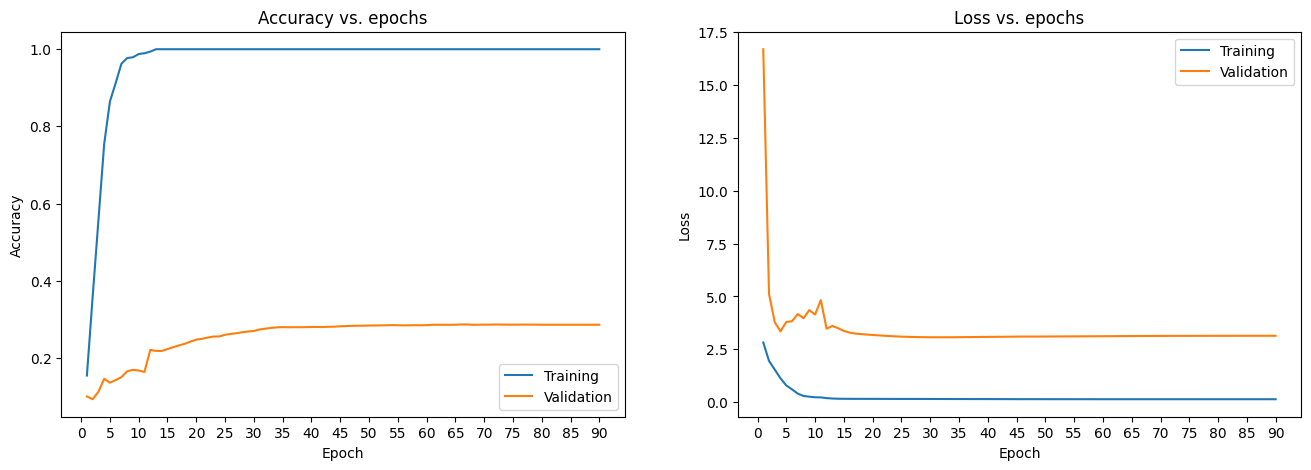

2022-08-16 10:11:30,950: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-16 10:11:42,414: INFO: test loss:3.1298
2022-08-16 10:11:42,414: INFO: test accuracy:0.2866
2022-08-16 10:11:42,419: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-16 10:11:42,420: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-16 10:11:42,421: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator
2022-08-16 10:11:42,423: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator
2022-08-16 10:11:42,423: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 10:11:44,107: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator


313/313 [==============================] - 1s 3ms/step


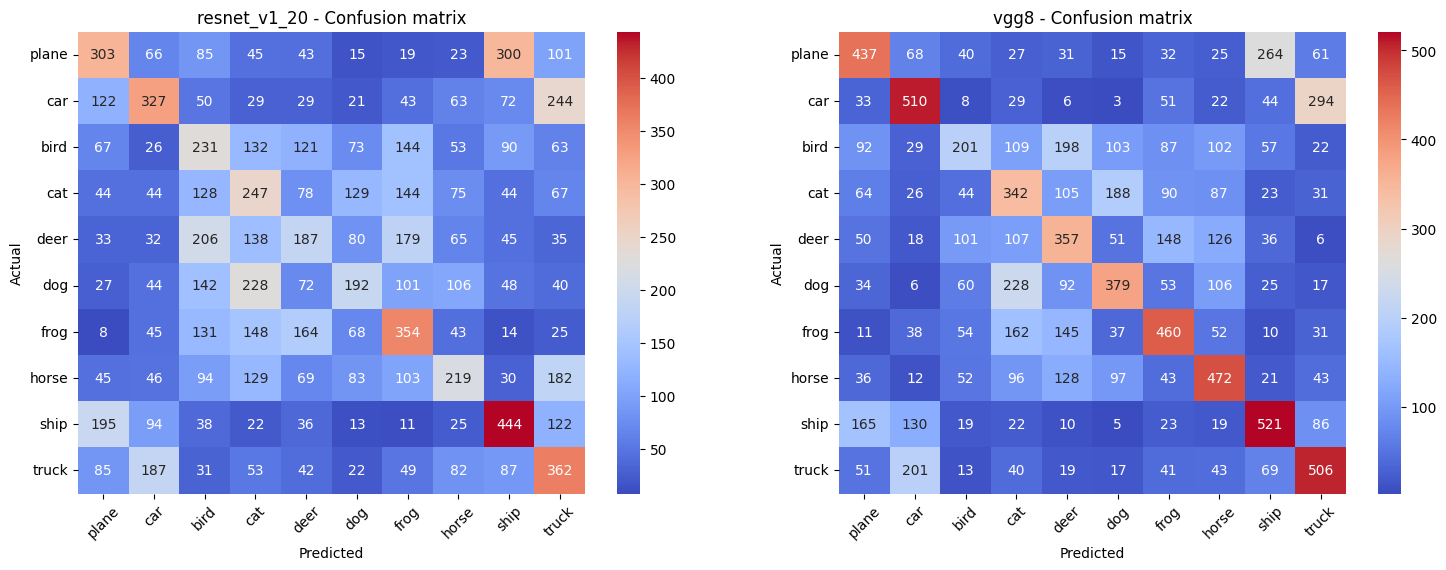

----------------------------------------models----------------------------------------


model_name               program_name  weight_number  train_time  \
1          vgg8  cifar10_0816_cnt_50.ipynb        1672906       273.6   
2       custom1  cifar10_0816_cnt_50.ipynb          73738       249.3   
3        lenet1  cifar10_0816_cnt_50.ipynb          83170       175.8   
4          mlp1  cifar10_0816_cnt_50.ipynb         394634        86.5   
5  resnet_v1_20  cifar10_0816_cnt_50.ipynb         273066       709.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:59      0.1492     2.8066           0.974         0.4185   
2  2022-08-16 09:54      0.2715     2.0175           0.952         0.3855   
3  2022-08-16 09:50      0.1424     2.6365           0.962         0.3511   
4  2022-08-16 09:47      1.2401     2.0180           0.646         0.2973   
5  2022-08-16 10:11      0.3014     3.1298           0.962         0.2866   

   train_auc  test_auc  
1     0.9965    0.8281  
2     0.9943    0.8181  
3     0.9979    0.7828  
4     0.9260    0.7458  
5     0.9987    0.7261

In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [42]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ResizeLayer, self).__init__()
        self.shape = shape

    def call(self, inputs, training=False):
#         print(type(inputs))
#         return tf.convert_to_tensor(resize_images(inputs.numpy(), self.shape))
        return tf.image.resize(inputs, self.shape)

In [43]:
rescale1 = tf.keras.layers.Rescaling(1./127.5, offset=-1)
input_shape = [160, 160, 3]

In [44]:
preprocess_fun =  [ResizeLayer(input_shape[:-1]), rescale1]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


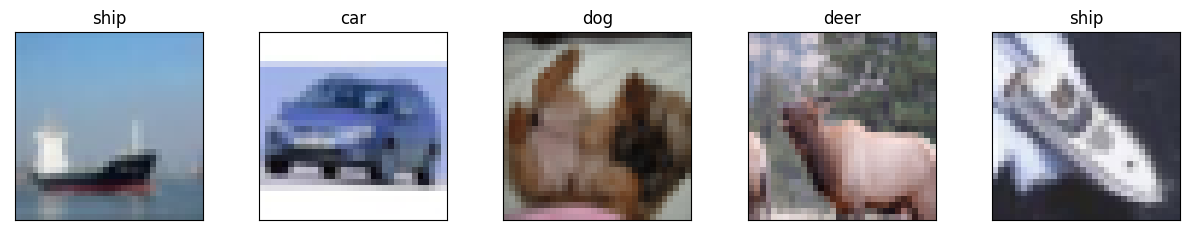

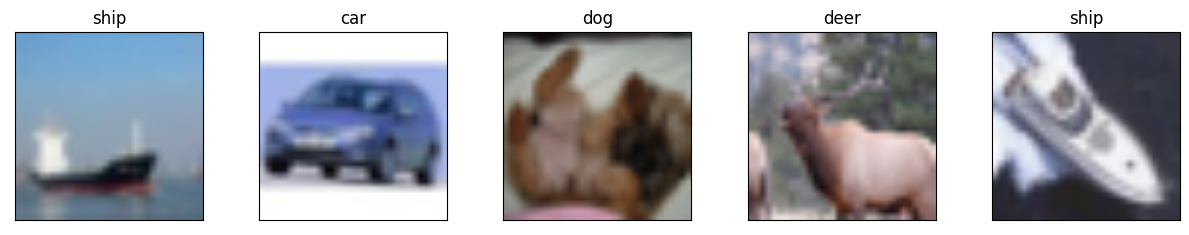

In [45]:
sample_images1 = ResizeLayer(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))

#### MobileNet V2

In [46]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [47]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [48]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-18 19:39:14,101: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-18 19:39:14,102: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-18 19:39:14,114: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resize_layer (ResizeLayer)  (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (D

2022-08-18 19:39:23,902: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-18 19:39:23,903: INFO: steps_per_epoch=15
2022-08-18 19:39:23,904: INFO: start training
2022-08-18 19:39:23,905: INFO: use_class_weight=False


Epoch 1/10
13/15 [=========================>....] - ETA: 0s - loss: 2.8941 - accuracy: 0.1250

2022-08-18 19:39:48,692: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:39:53,522: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 30s 2s/step - loss: 2.9155 - accuracy: 0.1208 - val_loss: 2.6434 - val_accuracy: 0.1255
Epoch 2/10
13/15 [=========================>....] - ETA: 0s - loss: 2.6735 - accuracy: 0.1322

2022-08-18 19:40:16,290: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:40:21,074: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 2.6780 - accuracy: 0.1292 - val_loss: 2.4723 - val_accuracy: 0.1522
Epoch 3/10
13/15 [=========================>....] - ETA: 0s - loss: 2.4285 - accuracy: 0.1587

2022-08-18 19:40:43,816: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:40:48,511: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 27s 2s/step - loss: 2.4216 - accuracy: 0.1646 - val_loss: 2.3484 - val_accuracy: 0.1792
Epoch 4/10
13/15 [=========================>....] - ETA: 0s - loss: 2.3763 - accuracy: 0.2019

2022-08-18 19:41:11,758: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:41:16,273: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 2.3910 - accuracy: 0.2000 - val_loss: 2.2382 - val_accuracy: 0.2107
Epoch 5/10
13/15 [=========================>....] - ETA: 0s - loss: 2.1809 - accuracy: 0.2476

2022-08-18 19:41:39,135: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:41:43,479: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 27s 2s/step - loss: 2.1917 - accuracy: 0.2396 - val_loss: 2.1375 - val_accuracy: 0.2408
Epoch 6/10
13/15 [=========================>....] - ETA: 0s - loss: 2.0897 - accuracy: 0.2452

2022-08-18 19:42:06,489: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:42:11,244: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 2.1025 - accuracy: 0.2500 - val_loss: 2.0461 - val_accuracy: 0.2728
Epoch 7/10
13/15 [=========================>....] - ETA: 0s - loss: 1.9573 - accuracy: 0.3149

2022-08-18 19:42:34,625: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:42:39,444: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 1.9876 - accuracy: 0.3042 - val_loss: 1.9586 - val_accuracy: 0.3054
Epoch 8/10
13/15 [=========================>....] - ETA: 0s - loss: 1.8943 - accuracy: 0.3365

2022-08-18 19:43:02,185: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:43:06,961: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 27s 2s/step - loss: 1.8938 - accuracy: 0.3396 - val_loss: 1.8770 - val_accuracy: 0.3357
Epoch 9/10
13/15 [=========================>....] - ETA: 0s - loss: 1.8123 - accuracy: 0.3702

2022-08-18 19:43:30,056: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:43:34,906: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 1.7976 - accuracy: 0.3792 - val_loss: 1.8049 - val_accuracy: 0.3638
Epoch 10/10
13/15 [=========================>....] - ETA: 0s - loss: 1.6642 - accuracy: 0.4159

2022-08-18 19:43:57,650: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:44:02,412: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 27s 2s/step - loss: 1.6820 - accuracy: 0.4083 - val_loss: 1.7376 - val_accuracy: 0.3928


2022-08-18 19:44:03,116: INFO: finish training [elapsed time: 279.21 seconds]


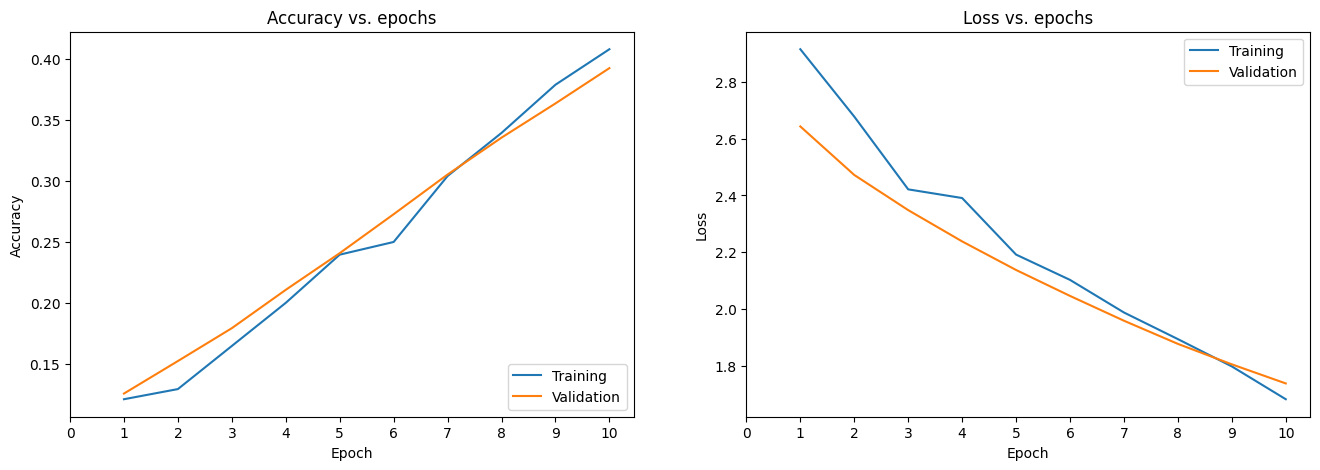

In [49]:
history = helper.train(model, epochs=10, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))

In [50]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-18 19:44:03,793: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-18 19:44:03,794: INFO: steps_per_epoch=15
2022-08-18 19:44:03,795: INFO: start training
2022-08-18 19:44:03,795: INFO: use_class_weight=False


Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 1.5103 - accuracy: 0.4521

2022-08-18 19:44:33,248: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:44:38,263: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 35s 2s/step - loss: 1.5103 - accuracy: 0.4521 - val_loss: 1.3535 - val_accuracy: 0.5443
Epoch 2/15
15/15 [==============================] - ETA: 0s - loss: 1.0812 - accuracy: 0.6313

2022-08-18 19:45:03,289: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:45:08,150: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 30s 2s/step - loss: 1.0812 - accuracy: 0.6313 - val_loss: 1.1936 - val_accuracy: 0.5946
Epoch 3/15
15/15 [==============================] - ETA: 0s - loss: 0.9192 - accuracy: 0.7083

2022-08-18 19:45:32,573: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:45:37,729: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 30s 2s/step - loss: 0.9192 - accuracy: 0.7083 - val_loss: 1.0848 - val_accuracy: 0.6326
Epoch 4/15
15/15 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.7833

2022-08-18 19:46:01,207: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:46:06,028: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 0.7132 - accuracy: 0.7833 - val_loss: 1.0140 - val_accuracy: 0.6534
Epoch 5/15
15/15 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.7958

2022-08-18 19:46:29,388: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:46:34,418: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 0.6124 - accuracy: 0.7958 - val_loss: 0.9539 - val_accuracy: 0.6726
Epoch 6/15
15/15 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.8438

2022-08-18 19:48:23,192: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:48:27,961: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 0.3030 - accuracy: 0.9417 - val_loss: 0.8329 - val_accuracy: 0.7141
Epoch 10/15
15/15 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.9208

2022-08-18 19:48:51,390: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:48:56,405: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 0.2782 - accuracy: 0.9208 - val_loss: 0.8007 - val_accuracy: 0.7270
Epoch 11/15
15/15 [==============================] - 7s 497ms/step - loss: 0.2582 - accuracy: 0.9354 - val_loss: 0.7933 - val_accuracy: 0.7248
Epoch 12/15
15/15 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9479

2022-08-18 19:49:26,753: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:49:31,873: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 0.2095 - accuracy: 0.9479 - val_loss: 0.7873 - val_accuracy: 0.7313
Epoch 13/15
15/15 [==============================] - 7s 497ms/step - loss: 0.1832 - accuracy: 0.9604 - val_loss: 0.8002 - val_accuracy: 0.7272
Epoch 14/15
15/15 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9708

2022-08-18 19:50:02,321: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:50:07,492: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 29s 2s/step - loss: 0.1418 - accuracy: 0.9708 - val_loss: 0.7690 - val_accuracy: 0.7379
Epoch 15/15
15/15 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9667

2022-08-18 19:50:30,681: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


2022-08-18 19:50:35,771: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2/assets


15/15 [==============================] - 28s 2s/step - loss: 0.1406 - accuracy: 0.9667 - val_loss: 0.7405 - val_accuracy: 0.7474


2022-08-18 19:50:36,504: INFO: finish training [elapsed time: 392.71 seconds]


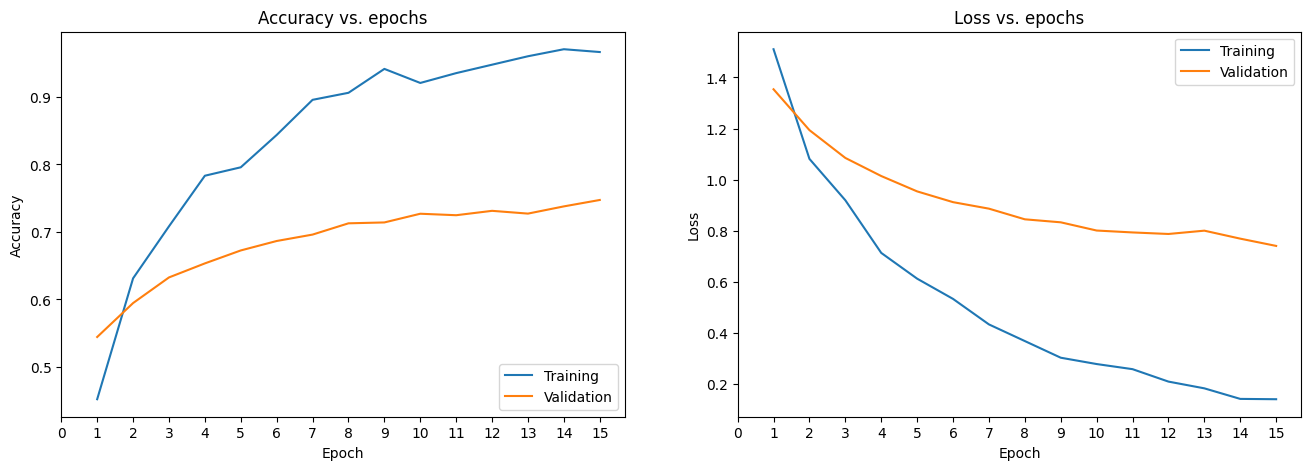

2022-08-18 19:50:36,888: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 6s 20ms/step


2022-08-18 19:51:03,290: INFO: test loss:0.7405
2022-08-18 19:51:03,291: INFO: test accuracy:0.7474
2022-08-18 19:51:03,294: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json


----------------------------------------save model results and generator----------------------------------------


2022-08-18 19:51:03,296: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/results.json
2022-08-18 19:51:03,297: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator
2022-08-18 19:51:03,298: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator
2022-08-18 19:51:03,299: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/vgg8


----------------------------------------confusion matrix----------------------------------------


2022-08-18 19:51:04,804: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_50/default.generator


313/313 [==============================] - 1s 3ms/step


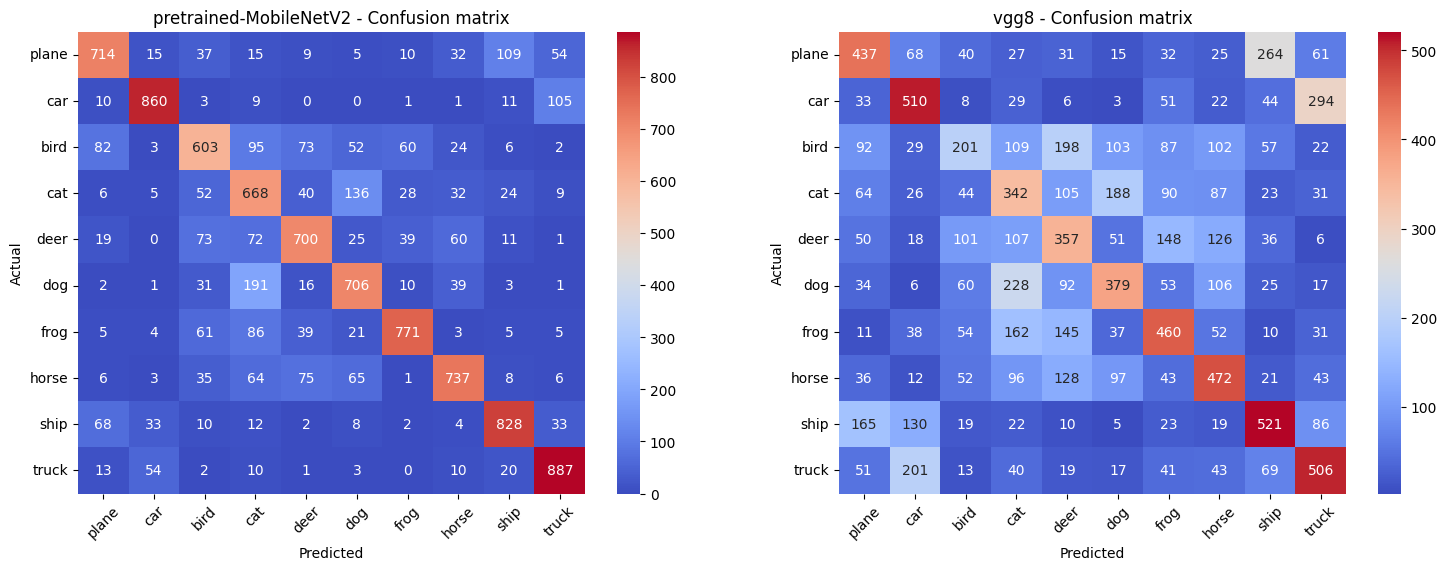

----------------------------------------models----------------------------------------


model_name               program_name  weight_number  \
1  pretrained-MobileNetV2  cifar10_0816_cnt_50.ipynb        1874250   
2                    vgg8  cifar10_0816_cnt_50.ipynb        1672906   
3                 custom1  cifar10_0816_cnt_50.ipynb          73738   
4                  lenet1  cifar10_0816_cnt_50.ipynb          83170   
5                    mlp1  cifar10_0816_cnt_50.ipynb         394634   
6            resnet_v1_20  cifar10_0816_cnt_50.ipynb         273066   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1       392.7  2022-08-18 19:51      0.0873     0.7405           0.982   
2       273.6  2022-08-16 09:59      0.1492     2.8066           0.974   
3       249.3  2022-08-16 09:54      0.2715     2.0175           0.952   
4       175.8  2022-08-16 09:50      0.1424     2.6365           0.962   
5        86.5  2022-08-16 09:47      1.2401     2.0180           0.646   
6       709.6  2022-08-16 10:11      0.3014     3.1298           0.962   

   test_accuracy  train_auc  test_auc  
1         0.7474     0.9987    0.9664  
2         0.4185     0.9965    0.8281  
3         0.3855     0.9943    0.8181  
4         0.3511     0.9979    0.7828  
5         0.2973     0.9260    0.7458  
6         0.2866     0.9987    0.7261

In [51]:
history = helper.train(model, epochs=15, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [52]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-18 19:51:14,412: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-18 19:51:14,414: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-18 19:51:14,415: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-18 19:51:14,417: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-18 19:51:14,418: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-18 19:51:14,419: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/ima

model_name                       program_name  weight_number  \
1   pretrained-MobileNetV2  cifar10_0816_cnt_5000_aug_1.ipynb        1874250   
2   pretrained-MobileNetV2        cifar10_0816_cnt_5000.ipynb        1874250   
3   pretrained-MobileNetV2    cifar10_0816_cnt_5000_aug.ipynb        1874250   
4   pretrained-MobileNetV2        cifar10_0816_cnt_2000.ipynb        1874250   
5   pretrained-MobileNetV2        cifar10_0816_cnt_1000.ipynb        1874250   
6                     vgg8        cifar10_0816_cnt_5000.ipynb        1672906   
7   pretrained-MobileNetV2         cifar10_0816_cnt_500.ipynb        1874250   
8   pretrained-MobileNetV2         cifar10_0816_cnt_200.ipynb        1874250   
9                     vgg8        cifar10_0816_cnt_2000.ipynb        1672906   
10            resnet_v1_20        cifar10_0816_cnt_5000.ipynb         273066   

    train_time       create_time  train_loss  test_loss  train_accuracy  \
1       1414.6  2022-08-17 05:31      0.1048     0.2324          0.9630   
2       1096.1  2022-08-16 12:32      0.0215     0.3150          0.9938   
3       1517.0  2022-08-17 06:29      0.1540     0.2510          0.9470   
4        762.3  2022-08-16 11:22      0.0112     0.4282          0.9976   
5        598.4  2022-08-16 09:26      0.0212     0.4112          0.9963   
6       2113.1  2022-08-16 11:13      0.0005     0.8218          0.9999   
7        487.0  2022-08-16 09:53      0.0125     0.4696          0.9992   
8        427.4  2022-08-16 09:54      0.0315     0.5364          0.9960   
9       1019.2  2022-08-16 10:31      0.0003     1.2263          1.0000   
10      2852.6  2022-08-16 12:02      0.1742     1.3372          0.9971   

    test_accuracy  train_auc  test_auc  
1          0.9312     0.9992    0.9967  
2          0.9260     1.0000    0.9964  
3          0.9199     0.9982    0.9958  
4          0.9058     1.0000    0.9944  
5          0.8930     1.0000    0.9929  
6          0.8845     1.0000    0.9893  
7          0.8778     1.0000    0.9906  
8          0.8412     1.0000    0.9857  
9          0.8299     1.0000    0.9791  
10         0.8207     1.0000    0.9796

In [53]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-18 19:51:14,597: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2
2022-08-18 19:51:24,348: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/val_test.generator
2022-08-18 19:51:24,373: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2
2022-08-18 19:51:34,346: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-08-18 19:51:34,370: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2
2022-08-18 19:51:44,938: INFO: load

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 1s 898ms/step


2022-08-18 19:52:09,343: WARNING: 5 out of the last 317 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f9f80b1a0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 2s 2s/step


2022-08-18 19:52:10,258: WARNING: 6 out of the last 318 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f9f72b3d8b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 18ms/step


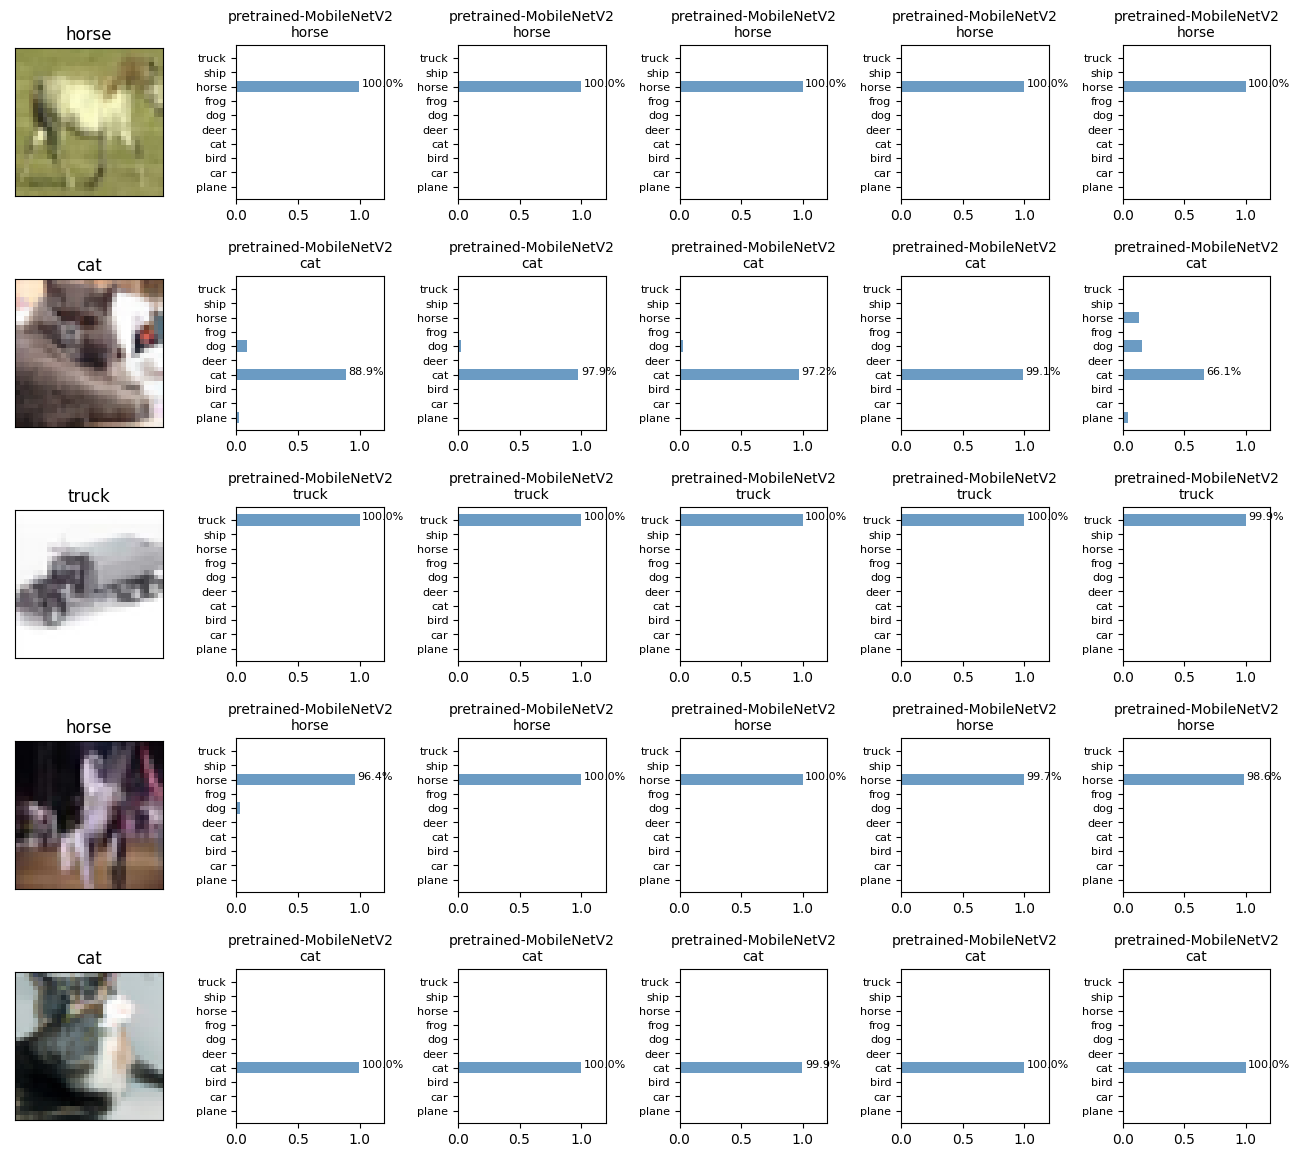

In [54]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 17ms/step


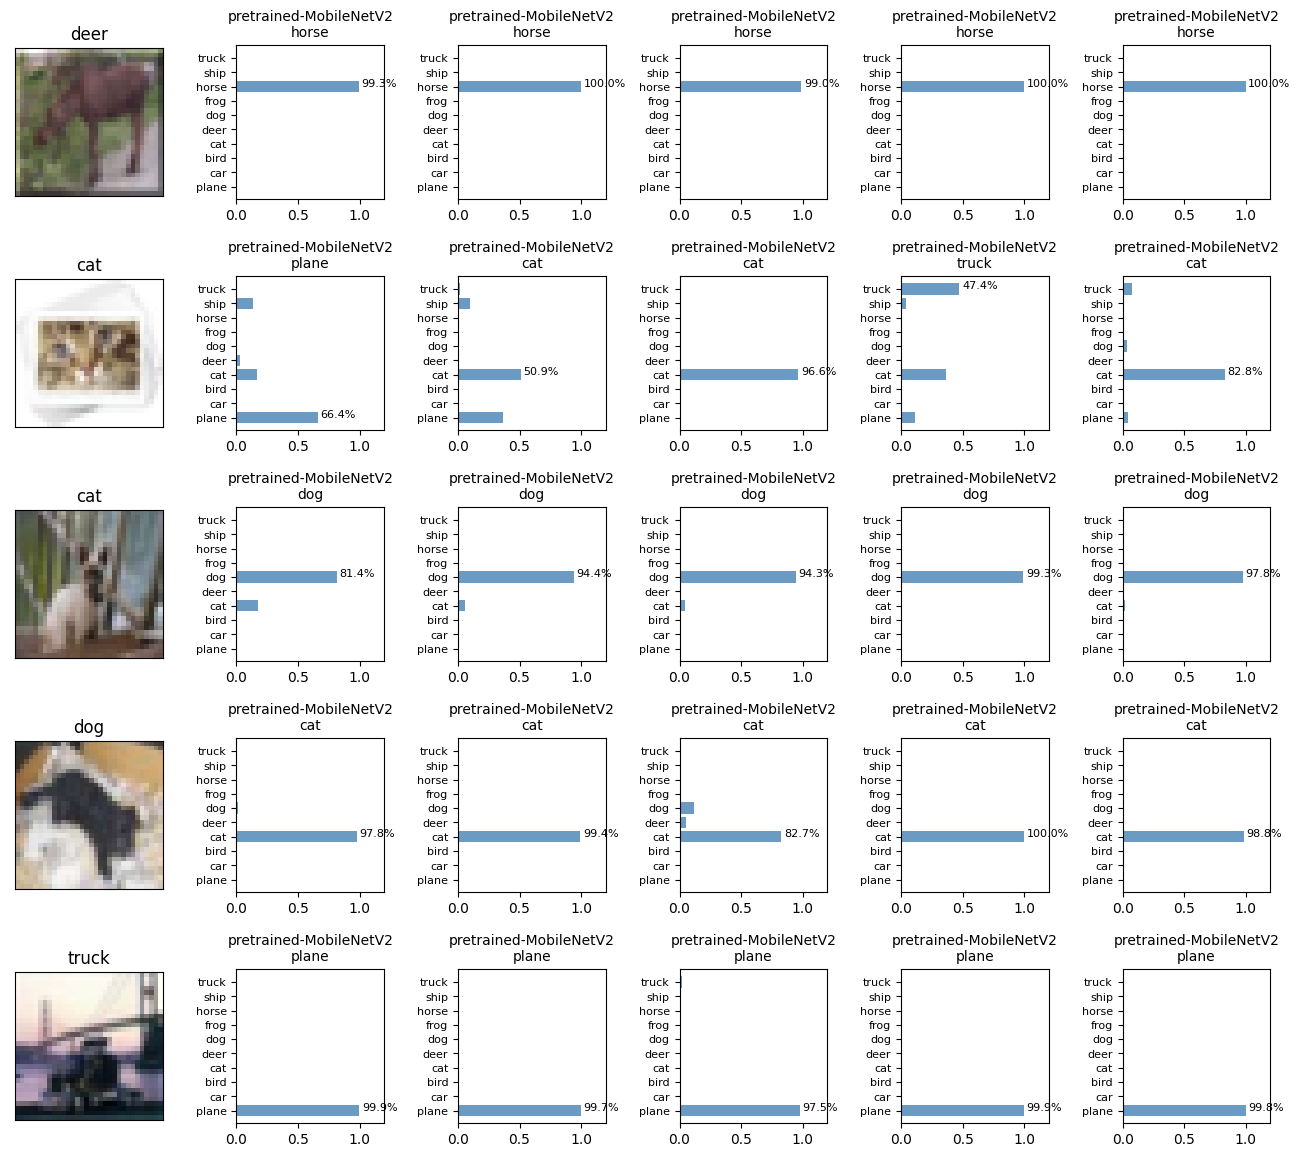

In [55]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [56]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.23238687217235565, 'accuracy': 0.9312000274658203, 'mae': 10.514875411987305}
313/313 [==============================] - 6s 20ms/step
(10000, 10)


In [57]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 6s 20ms/step


precision  recall        f1
plane   0.910462   0.966  0.937409
car     0.978659   0.963  0.970766
bird    0.940268   0.913  0.926433
cat     0.881799   0.843  0.861963
deer    0.892823   0.933  0.912469
dog     0.929806   0.861  0.894081
frog    0.913938   0.977  0.944418
horse   0.952333   0.939  0.945619
ship    0.971282   0.947  0.958987
truck   0.944499   0.970  0.957079

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9105    0.9660    0.9374      1000
         car     0.9787    0.9630    0.9708      1000
        bird     0.9403    0.9130    0.9264      1000
         cat     0.8818    0.8430    0.8620      1000
        deer     0.8928    0.9330    0.9125      1000
         dog     0.9298    0.8610    0.8941      1000
        frog     0.9139    0.9770    0.9444      1000
       horse     0.9523    0.9390    0.9456      1000
        ship     0.9713    0.9470    0.9590      1000
       truck     0.9445    0.9700    0.9571      1000

    accuracy                         0.9312     10000
   macro avg     0.9316    0.9312    0.9309     10000
weighted avg     0.9316    0.9312    0.9309     10000



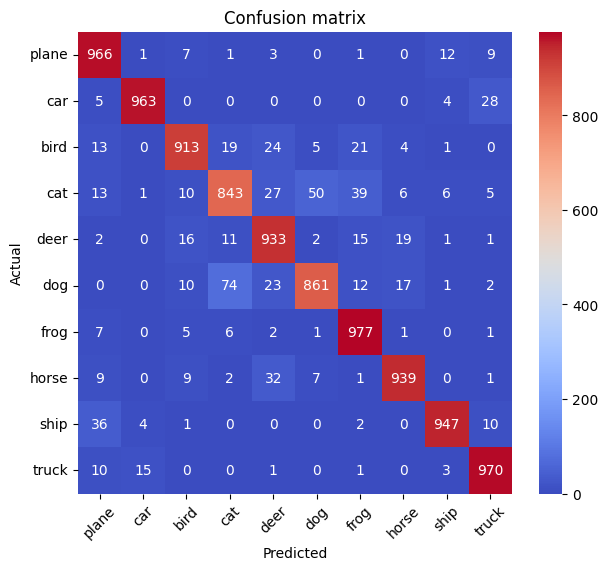

In [58]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)